In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import pickle as pkl
from tqdm import tqdm
import wandb
import random
from model import *

In [9]:
eta =1
seed = 2051
# with open(f'./data/rho=0.3/p=0.3_eta={eta}_L=64_pdf_{2050}.pkl','rb') as f:
with open(f'./data/rho=0.3/p=0.3_eta={eta}_L=64_field_{2050}.pkl','rb') as f:
    data = pkl.load(f)
    field = data['field']
field = field.mean(0)[np.newaxis,:]
field.shape

(1, 300, 64, 64, 3)

In [10]:
field.shape

(1, 300, 64, 64, 3)

In [11]:

n_steps_in, n_steps_out = (4,4)#(2,2)#

data_x, data_y = [], []
for i in tqdm(range(field.shape[1]  - n_steps_in - n_steps_out + 1)):
    data_x.append(field[:,i:i+n_steps_in])
    data_y.append(field[:,i+n_steps_in:i+n_steps_in+n_steps_out,:,:,:])
data_x, data_y = np.array(data_x), np.array(data_y)

data_x.shape,data_y.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 293/293 [00:00<00:00, 204583.16it/s]


((293, 1, 4, 64, 64, 3), (293, 1, 4, 64, 64, 3))

In [12]:
data_x = torch.tensor(data_x,dtype=torch.float)
data_y = torch.tensor(data_y,dtype=torch.float)

data_x = torch.transpose(data_x,0,1)
data_y = torch.transpose(data_y,0,1)
print(data_y.shape,data_x.shape)

L = field.shape[-2]
data_x = data_x.reshape(-1,n_steps_in,L,L,3)
data_y = data_y.reshape(-1,n_steps_out,L,L,3)
batch_size = 32
data_x.shape,data_y.shape

torch.Size([1, 293, 4, 64, 64, 3]) torch.Size([1, 293, 4, 64, 64, 3])


(torch.Size([293, 4, 64, 64, 3]), torch.Size([293, 4, 64, 64, 3]))

In [13]:
# data_x = data_x.reshape()
train_data_x = data_x[:int(0.6*data_x.shape[0]),:,:,:,:]
train_data_y = data_y[:int(0.6*data_x.shape[0]),:,:,:,:]

valid_data_x = data_x[int(0.6*data_x.shape[0]):int(0.8*data_x.shape[0]),:,:,:,:]
valid_data_y = data_y[int(0.6*data_x.shape[0]):int(0.8*data_x.shape[0]),:,:,:,:]

dataset1 = torch.utils.data.dataset.TensorDataset(train_data_x, train_data_y)
dataset2 = torch.utils.data.dataset.TensorDataset(valid_data_x, valid_data_y)


train_loader = torch.utils.data.DataLoader(dataset=dataset1,
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           drop_last=False)
valid_loader = torch.utils.data.DataLoader(dataset=dataset2,
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           drop_last=False)


In [14]:
class Normalization_temp(nn.Module):
    def __init__(self, group_size=(2,2), input_dim=3, output_dim=3):
        super(Normalization_temp, self).__init__()
        # Modify the encoder layers
        self.encoder = nn.Sequential(
            nn.Conv3d(in_channels=input_dim, out_channels=16, 
                      kernel_size=(group_size[0],group_size[1],group_size[1]),
                      stride=(group_size[0],group_size[1],group_size[1])),#ke
            nn.ReLU(),
        ) 
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(in_channels=input_dim, out_channels=16,
                               kernel_size=(group_size[0],group_size[1],group_size[1]),
                               stride=(group_size[0],group_size[1],group_size[1])),
            nn.ReLU(),
        )
        self.mlp1 = nn.Linear(16,output_dim)
        self.mlp2 = nn.Linear(16,output_dim)
    def forward(self, x):
        return x
    def Encoder(self,x):
        b,t,l,_,f = x.shape
        x = x.permute(0, 4, 1, 2, 3) #b*t*f*l*l
        x = self.encoder(x)
        x = x.permute(0, 2, 3, 4, 1)#b*t*l*l*f
        x = self.mlp1(x)
        b,t,l,_,f = x.shape
        x = nn.functional.softmax(x.reshape(b,t,l*l,f),dim=-2).reshape(b,t,l,l,f)
        return x
    def Decoder(self,x):
        b,t,l,_,f = x.shape
#         print(x.shape)
        x = x.permute(0, 4, 1, 2, 3)
        x = self.decoder(x)
        x = x.permute(0, 2, 3, 4, 1)
        x = self.mlp2(x)
#         b,t,l,_,f = x.shape
#         x = nn.functional.softmax(x.reshape(b,t,l*l,f),dim=-2).reshape(b,t,l,l,f)
        return x
# class DynamicLearner(nn.Module):
#     def __init__(self,input_dim=1,output_dim=1):
#         super(DynamicLearner, self).__init__()
# #         self.hidden_dim = hidden_dim
        
#         self.channel = 5
# #         self.time_range_out = time_range_out
#         self.input_dim=input_dim
#         self.output_dim=output_dim
# #         self.time_range = time_range
#         self.kernel_size = 3
#         self.conv2d1 = nn.Conv2d(input_dim, self.channel, kernel_size = self.kernel_size, padding = 1)  
#         self.conv2d2 = nn.Conv2d(self.channel, self.channel, kernel_size = self.kernel_size, padding = 1)  
#         self.mlp1 = nn.Linear(self.channel,output_dim)
#         self.relu = nn.ReLU()
#     def forward(self, xx):
#         'x.shape: b,t,l,l,f'
#         b,t,l,_,f = xx.shape
#         x = xx.reshape(b*t,l,l,t).permute(0,3,1,2)
#         x = self.relu(self.conv2d1(x))##b,c,l,l
#         x = self.relu(self.conv2d2(x))##b,c,l,l
#         x = x.permute(0,2,3,1).reshape(b,t,l,l,self.channel)
#         x = self.mlp1(x)
#         x = nn.functional.softmax(x.reshape(b,t,l*l,f),dim=2).reshape(b,t,l,l,f)
#         return x
        


In [15]:
NEAR_0 = 1e-10
loss_F = torch.nn.MSELoss(reduction='sum')
torch.manual_seed(seed)
lr = 0.001
epochs = 1000
group_size=(4,2)#time,spatial


In [16]:
eta,group_size,seed

(1, (4, 2), 2051)

In [17]:
# dynamic = torch.load(f'./models/78/field_dynamic_n=78_eta={eta}_seed={seed}_pdf.pth')
dynamic = torch.load(f'./models/307/field_dynamic_n=307_eta={eta}_seed={seed}.pth')

  0%|                                                                                                                       | 0/500 [00:00<?, ?it/s]

Epoch 000, train decoder Loss: 35622.68912760
save
--------Epoch 000, valid decoder Loss: 33803.63476562, macro Loss: 12.23558283, mean Loss: nan


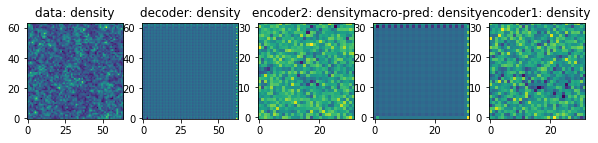

  0%|▍                                                                                                              | 2/500 [00:01<06:32,  1.27it/s]

Epoch 001, train decoder Loss: 32381.50651042


  1%|▋                                                                                                              | 3/500 [00:02<05:57,  1.39it/s]

Epoch 002, train decoder Loss: 29719.71305339


  1%|▉                                                                                                              | 4/500 [00:02<05:42,  1.45it/s]

Epoch 003, train decoder Loss: 27451.78499349


  1%|█                                                                                                              | 5/500 [00:03<05:38,  1.46it/s]

Epoch 004, train decoder Loss: 25505.51302083
Epoch 005, train decoder Loss: 23827.30761719
save
--------Epoch 005, valid decoder Loss: 23232.22656250, macro Loss: 12.23525953, mean Loss: nan


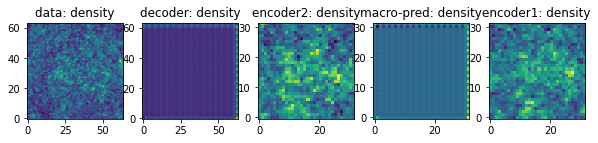

  1%|█▌                                                                                                             | 7/500 [00:05<06:07,  1.34it/s]

Epoch 006, train decoder Loss: 22377.62369792


  2%|█▊                                                                                                             | 8/500 [00:05<05:50,  1.40it/s]

Epoch 007, train decoder Loss: 21083.81347656


  2%|█▉                                                                                                             | 9/500 [00:06<05:38,  1.45it/s]

Epoch 008, train decoder Loss: 19955.47639974


  2%|██▏                                                                                                           | 10/500 [00:07<05:33,  1.47it/s]

Epoch 009, train decoder Loss: 18990.23828125
Epoch 010, train decoder Loss: 18192.00146484
save
--------Epoch 010, valid decoder Loss: 18110.39648438, macro Loss: 12.23490620, mean Loss: nan


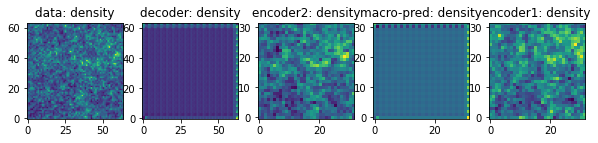

  2%|██▋                                                                                                           | 12/500 [00:08<06:00,  1.35it/s]

Epoch 011, train decoder Loss: 17554.78466797


  3%|██▊                                                                                                           | 13/500 [00:09<05:44,  1.41it/s]

Epoch 012, train decoder Loss: 17070.22460938


  3%|███                                                                                                           | 14/500 [00:10<05:36,  1.44it/s]

Epoch 013, train decoder Loss: 16723.51285807


  3%|███▎                                                                                                          | 15/500 [00:10<05:28,  1.48it/s]

Epoch 014, train decoder Loss: 16492.92154948
Epoch 015, train decoder Loss: 16353.93001302
save
--------Epoch 015, valid decoder Loss: 16688.92871094, macro Loss: 12.23643875, mean Loss: nan


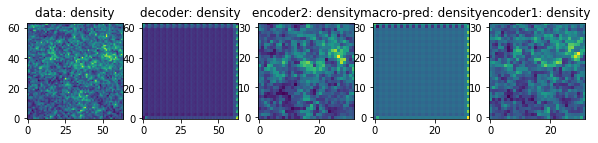

  3%|███▋                                                                                                          | 17/500 [00:12<05:51,  1.37it/s]

Epoch 016, train decoder Loss: 16279.64453125


  4%|███▉                                                                                                          | 18/500 [00:13<05:40,  1.42it/s]

Epoch 017, train decoder Loss: 16246.09635417


  4%|████▏                                                                                                         | 19/500 [00:13<05:32,  1.45it/s]

Epoch 018, train decoder Loss: 16234.78059896


  4%|████▍                                                                                                         | 20/500 [00:14<05:26,  1.47it/s]

Epoch 019, train decoder Loss: 16232.60253906
Epoch 020, train decoder Loss: 16233.18570964
save
--------Epoch 020, valid decoder Loss: 16643.85253906, macro Loss: 12.24539709, mean Loss: nan


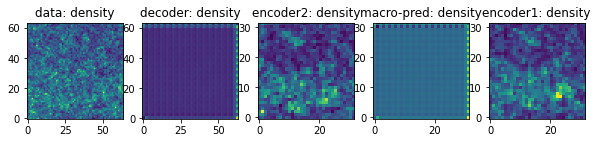

  4%|████▊                                                                                                         | 22/500 [00:15<05:52,  1.36it/s]

Epoch 021, train decoder Loss: 16233.53987630


  5%|█████                                                                                                         | 23/500 [00:16<05:37,  1.41it/s]

Epoch 022, train decoder Loss: 16233.30289714


  5%|█████▎                                                                                                        | 24/500 [00:17<05:26,  1.46it/s]

Epoch 023, train decoder Loss: 16232.71175130


  5%|█████▌                                                                                                        | 25/500 [00:17<05:29,  1.44it/s]

Epoch 024, train decoder Loss: 16232.12060547
Epoch 025, train decoder Loss: 16231.63248698
save
--------Epoch 025, valid decoder Loss: 16638.79882812, macro Loss: 12.27427435, mean Loss: nan


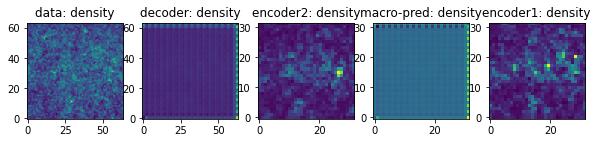

  5%|█████▉                                                                                                        | 27/500 [00:19<05:53,  1.34it/s]

Epoch 026, train decoder Loss: 16231.31152344


  6%|██████▏                                                                                                       | 28/500 [00:20<05:40,  1.39it/s]

Epoch 027, train decoder Loss: 16231.06608073


  6%|██████▍                                                                                                       | 29/500 [00:20<05:28,  1.43it/s]

Epoch 028, train decoder Loss: 16230.84505208


  6%|██████▌                                                                                                       | 30/500 [00:21<05:20,  1.46it/s]

Epoch 029, train decoder Loss: 16230.63085938
Epoch 030, train decoder Loss: 16230.39518229
save
--------Epoch 030, valid decoder Loss: 16637.04589844, macro Loss: 12.35729265, mean Loss: nan


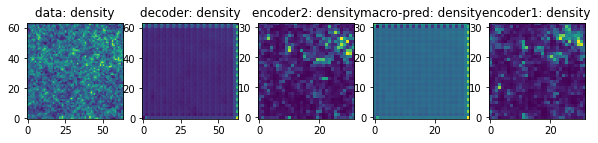

  6%|███████                                                                                                       | 32/500 [00:23<05:46,  1.35it/s]

Epoch 031, train decoder Loss: 16230.15136719


  7%|███████▎                                                                                                      | 33/500 [00:23<05:31,  1.41it/s]

Epoch 032, train decoder Loss: 16229.88297526


  7%|███████▍                                                                                                      | 34/500 [00:24<05:21,  1.45it/s]

Epoch 033, train decoder Loss: 16229.66829427


  7%|███████▋                                                                                                      | 35/500 [00:25<05:15,  1.47it/s]

Epoch 034, train decoder Loss: 16229.34570312
Epoch 035, train decoder Loss: 16229.05094401
save
--------Epoch 035, valid decoder Loss: 16636.05761719, macro Loss: 12.65570545, mean Loss: nan


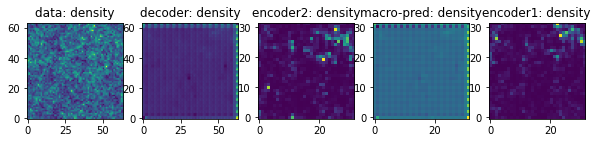

  7%|████████▏                                                                                                     | 37/500 [00:26<05:43,  1.35it/s]

Epoch 036, train decoder Loss: 16228.76318359


  8%|████████▎                                                                                                     | 38/500 [00:27<05:30,  1.40it/s]

Epoch 037, train decoder Loss: 16228.42480469


  8%|████████▌                                                                                                     | 39/500 [00:28<05:21,  1.43it/s]

Epoch 038, train decoder Loss: 16228.13899740


  8%|████████▊                                                                                                     | 40/500 [00:28<05:12,  1.47it/s]

Epoch 039, train decoder Loss: 16227.80403646
Epoch 040, train decoder Loss: 16227.48339844
save
--------Epoch 040, valid decoder Loss: 16634.75830078, macro Loss: 13.76509237, mean Loss: nan


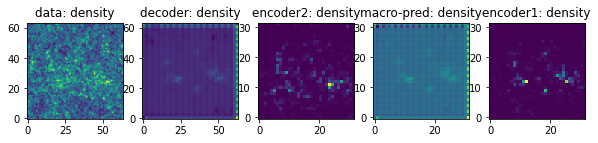

  8%|█████████▏                                                                                                    | 42/500 [00:30<05:33,  1.37it/s]

Epoch 041, train decoder Loss: 16227.18391927


  9%|█████████▍                                                                                                    | 43/500 [00:30<05:20,  1.43it/s]

Epoch 042, train decoder Loss: 16226.86539714


  9%|█████████▋                                                                                                    | 44/500 [00:31<05:10,  1.47it/s]

Epoch 043, train decoder Loss: 16226.56184896


  9%|█████████▉                                                                                                    | 45/500 [00:32<05:03,  1.50it/s]

Epoch 044, train decoder Loss: 16226.24511719
Epoch 045, train decoder Loss: 16225.92545573
save
--------Epoch 045, valid decoder Loss: 16632.93457031, macro Loss: 16.21467829, mean Loss: nan


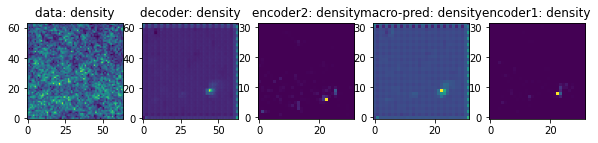

  9%|██████████▎                                                                                                   | 47/500 [00:33<05:26,  1.39it/s]

Epoch 046, train decoder Loss: 16225.59130859


 10%|██████████▌                                                                                                   | 48/500 [00:34<05:17,  1.42it/s]

Epoch 047, train decoder Loss: 16225.26253255


 10%|██████████▊                                                                                                   | 49/500 [00:35<05:11,  1.45it/s]

Epoch 048, train decoder Loss: 16224.95605469


 10%|███████████                                                                                                   | 50/500 [00:35<05:11,  1.45it/s]

Epoch 049, train decoder Loss: 16224.63216146
Epoch 050, train decoder Loss: 16224.29850260
save
--------Epoch 050, valid decoder Loss: 16631.08251953, macro Loss: 19.64233875, mean Loss: nan


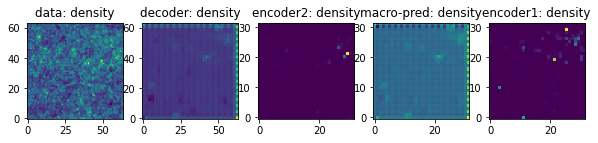

 10%|███████████▍                                                                                                  | 52/500 [00:37<05:29,  1.36it/s]

Epoch 051, train decoder Loss: 16223.97851562


 11%|███████████▋                                                                                                  | 53/500 [00:38<05:17,  1.41it/s]

Epoch 052, train decoder Loss: 16223.64095052


 11%|███████████▉                                                                                                  | 54/500 [00:38<05:08,  1.45it/s]

Epoch 053, train decoder Loss: 16223.34179688


 11%|████████████                                                                                                  | 55/500 [00:39<05:01,  1.48it/s]

Epoch 054, train decoder Loss: 16222.97819010
Epoch 055, train decoder Loss: 16222.67057292
save
--------Epoch 055, valid decoder Loss: 16630.51269531, macro Loss: 22.62886143, mean Loss: nan


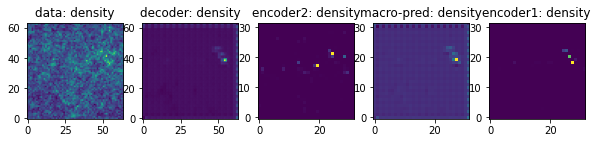

 11%|████████████▌                                                                                                 | 57/500 [00:41<05:27,  1.35it/s]

Epoch 056, train decoder Loss: 16222.32519531


 12%|████████████▊                                                                                                 | 58/500 [00:41<05:15,  1.40it/s]

Epoch 057, train decoder Loss: 16221.93375651


 12%|████████████▉                                                                                                 | 59/500 [00:42<05:09,  1.43it/s]

Epoch 058, train decoder Loss: 16221.61816406


 12%|█████████████▏                                                                                                | 60/500 [00:43<05:03,  1.45it/s]

Epoch 059, train decoder Loss: 16221.23258464
Epoch 060, train decoder Loss: 16220.87923177
save
--------Epoch 060, valid decoder Loss: 16629.14208984, macro Loss: 24.98349762, mean Loss: nan


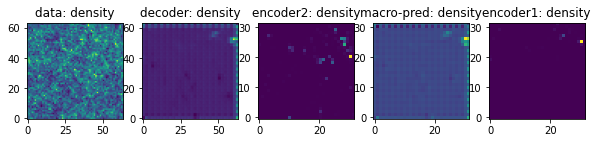

 12%|█████████████▋                                                                                                | 62/500 [00:44<05:28,  1.33it/s]

Epoch 061, train decoder Loss: 16220.53548177


 13%|█████████████▊                                                                                                | 63/500 [00:45<05:17,  1.38it/s]

Epoch 062, train decoder Loss: 16220.15218099


 13%|██████████████                                                                                                | 64/500 [00:46<05:08,  1.41it/s]

Epoch 063, train decoder Loss: 16219.77539062


 13%|██████████████▎                                                                                               | 65/500 [00:46<05:01,  1.44it/s]

Epoch 064, train decoder Loss: 16219.41536458
Epoch 065, train decoder Loss: 16219.04264323
save
--------Epoch 065, valid decoder Loss: 16627.75878906, macro Loss: 27.08127785, mean Loss: nan


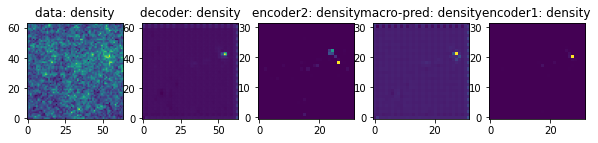

 13%|██████████████▋                                                                                               | 67/500 [00:48<05:23,  1.34it/s]

Epoch 066, train decoder Loss: 16218.67285156


 14%|██████████████▉                                                                                               | 68/500 [00:49<05:10,  1.39it/s]

Epoch 067, train decoder Loss: 16218.25195312


 14%|███████████████▏                                                                                              | 69/500 [00:49<04:59,  1.44it/s]

Epoch 068, train decoder Loss: 16217.86995443


 14%|███████████████▍                                                                                              | 70/500 [00:50<05:23,  1.33it/s]

Epoch 069, train decoder Loss: 16217.45947266
Epoch 070, train decoder Loss: 16217.07779948
save
--------Epoch 070, valid decoder Loss: 16626.23535156, macro Loss: 29.19081974, mean Loss: nan


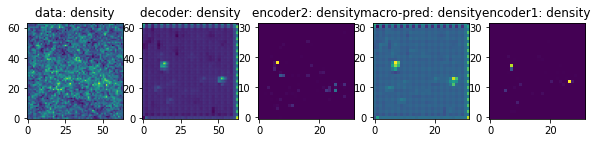

 14%|███████████████▊                                                                                              | 72/500 [00:52<05:31,  1.29it/s]

Epoch 071, train decoder Loss: 16216.68505859


 15%|████████████████                                                                                              | 73/500 [00:52<05:15,  1.35it/s]

Epoch 072, train decoder Loss: 16216.27294922


 15%|████████████████▎                                                                                             | 74/500 [00:53<05:05,  1.39it/s]

Epoch 073, train decoder Loss: 16215.87288411


 15%|████████████████▌                                                                                             | 75/500 [00:54<05:12,  1.36it/s]

Epoch 074, train decoder Loss: 16215.35774740
Epoch 075, train decoder Loss: 16214.69954427
save
--------Epoch 075, valid decoder Loss: 16624.64843750, macro Loss: 31.55066490, mean Loss: nan


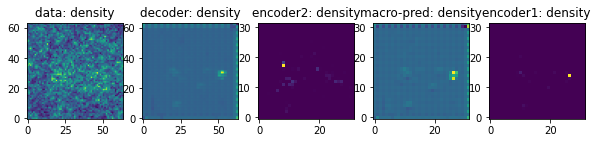

 15%|████████████████▉                                                                                             | 77/500 [00:55<05:27,  1.29it/s]

Epoch 076, train decoder Loss: 16214.06722005


 16%|█████████████████▏                                                                                            | 78/500 [00:56<05:12,  1.35it/s]

Epoch 077, train decoder Loss: 16213.17268880


 16%|█████████████████▍                                                                                            | 79/500 [00:57<05:01,  1.40it/s]

Epoch 078, train decoder Loss: 16212.22591146


 16%|█████████████████▌                                                                                            | 80/500 [00:57<04:54,  1.43it/s]

Epoch 079, train decoder Loss: 16211.20100911
Epoch 080, train decoder Loss: 16210.18717448
save
--------Epoch 080, valid decoder Loss: 16622.73535156, macro Loss: 32.34730530, mean Loss: nan


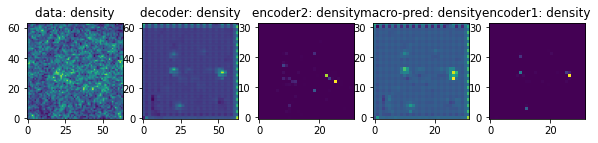

 16%|██████████████████                                                                                            | 82/500 [00:59<05:08,  1.36it/s]

Epoch 081, train decoder Loss: 16209.10172526


 17%|██████████████████▎                                                                                           | 83/500 [01:00<04:55,  1.41it/s]

Epoch 082, train decoder Loss: 16208.01367188


 17%|██████████████████▍                                                                                           | 84/500 [01:00<04:46,  1.45it/s]

Epoch 083, train decoder Loss: 16206.92171224


 17%|██████████████████▋                                                                                           | 85/500 [01:01<04:39,  1.48it/s]

Epoch 084, train decoder Loss: 16205.80419922
Epoch 085, train decoder Loss: 16204.74641927
save
--------Epoch 085, valid decoder Loss: 16618.35546875, macro Loss: 31.64508629, mean Loss: nan


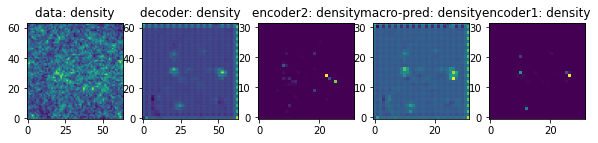

 17%|███████████████████▏                                                                                          | 87/500 [01:03<04:59,  1.38it/s]

Epoch 086, train decoder Loss: 16203.67919922


 18%|███████████████████▎                                                                                          | 88/500 [01:03<04:47,  1.43it/s]

Epoch 087, train decoder Loss: 16202.61263021


 18%|███████████████████▌                                                                                          | 89/500 [01:04<04:41,  1.46it/s]

Epoch 088, train decoder Loss: 16201.59147135


 18%|███████████████████▊                                                                                          | 90/500 [01:05<04:36,  1.48it/s]

Epoch 089, train decoder Loss: 16200.59505208
Epoch 090, train decoder Loss: 16199.57893880
save
--------Epoch 090, valid decoder Loss: 16616.41503906, macro Loss: 30.19689178, mean Loss: nan


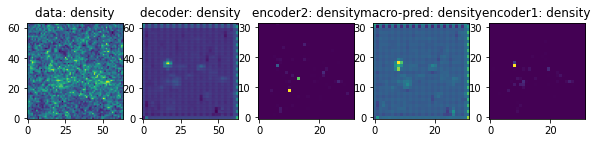

 18%|████████████████████▏                                                                                         | 92/500 [01:06<04:58,  1.37it/s]

Epoch 091, train decoder Loss: 16198.66389974


 19%|████████████████████▍                                                                                         | 93/500 [01:07<04:49,  1.40it/s]

Epoch 092, train decoder Loss: 16197.77897135


 19%|████████████████████▋                                                                                         | 94/500 [01:07<04:40,  1.45it/s]

Epoch 093, train decoder Loss: 16196.80468750


 19%|████████████████████▉                                                                                         | 95/500 [01:08<04:33,  1.48it/s]

Epoch 094, train decoder Loss: 16195.94498698
Epoch 095, train decoder Loss: 16194.96777344
save
--------Epoch 095, valid decoder Loss: 16612.06640625, macro Loss: 27.69852734, mean Loss: nan


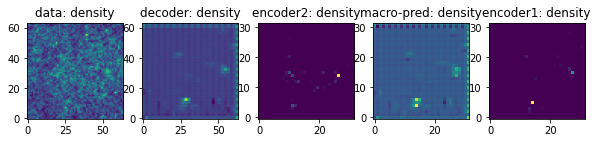

 19%|█████████████████████▎                                                                                        | 97/500 [01:10<04:54,  1.37it/s]

Epoch 096, train decoder Loss: 16193.98470052


 20%|█████████████████████▌                                                                                        | 98/500 [01:10<04:43,  1.42it/s]

Epoch 097, train decoder Loss: 16193.05305990


 20%|█████████████████████▊                                                                                        | 99/500 [01:11<04:35,  1.46it/s]

Epoch 098, train decoder Loss: 16192.19710286


 20%|█████████████████████▊                                                                                       | 100/500 [01:12<04:37,  1.44it/s]

Epoch 099, train decoder Loss: 16191.29248047
Epoch 100, train decoder Loss: 16190.30598958
save
--------Epoch 100, valid decoder Loss: 16609.11425781, macro Loss: 25.41724968, mean Loss: nan


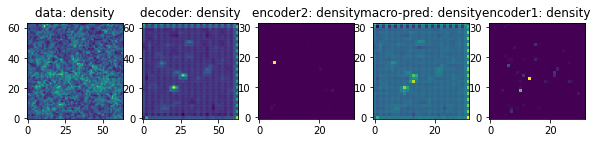

 20%|██████████████████████▏                                                                                      | 102/500 [01:13<04:56,  1.34it/s]

Epoch 101, train decoder Loss: 16189.35091146


 21%|██████████████████████▍                                                                                      | 103/500 [01:14<04:46,  1.39it/s]

Epoch 102, train decoder Loss: 16188.47249349


 21%|██████████████████████▋                                                                                      | 104/500 [01:15<04:35,  1.44it/s]

Epoch 103, train decoder Loss: 16187.47721354


 21%|██████████████████████▉                                                                                      | 105/500 [01:15<04:30,  1.46it/s]

Epoch 104, train decoder Loss: 16186.53678385
Epoch 105, train decoder Loss: 16185.62141927
save
--------Epoch 105, valid decoder Loss: 16606.55761719, macro Loss: 23.10124683, mean Loss: nan


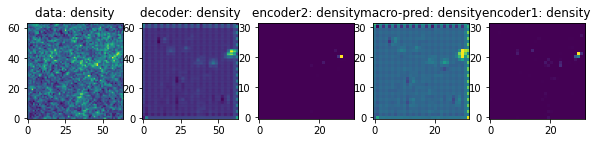

 21%|███████████████████████▎                                                                                     | 107/500 [01:17<04:47,  1.37it/s]

Epoch 106, train decoder Loss: 16184.71988932


 22%|███████████████████████▌                                                                                     | 108/500 [01:18<04:35,  1.42it/s]

Epoch 107, train decoder Loss: 16183.86442057


 22%|███████████████████████▊                                                                                     | 109/500 [01:18<04:27,  1.46it/s]

Epoch 108, train decoder Loss: 16182.86328125


 22%|███████████████████████▉                                                                                     | 110/500 [01:19<04:21,  1.49it/s]

Epoch 109, train decoder Loss: 16181.95996094
Epoch 110, train decoder Loss: 16181.01806641
save
--------Epoch 110, valid decoder Loss: 16602.27880859, macro Loss: 21.34028339, mean Loss: nan


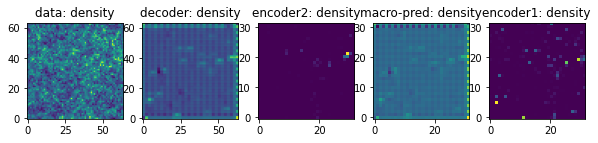

 22%|████████████████████████▍                                                                                    | 112/500 [01:20<04:44,  1.36it/s]

Epoch 111, train decoder Loss: 16180.10107422


 23%|████████████████████████▋                                                                                    | 113/500 [01:21<04:34,  1.41it/s]

Epoch 112, train decoder Loss: 16179.23258464


 23%|████████████████████████▊                                                                                    | 114/500 [01:22<04:26,  1.45it/s]

Epoch 113, train decoder Loss: 16178.34407552


 23%|█████████████████████████                                                                                    | 115/500 [01:22<04:21,  1.47it/s]

Epoch 114, train decoder Loss: 16177.52229818
Epoch 115, train decoder Loss: 16176.50032552
save
--------Epoch 115, valid decoder Loss: 16597.51367188, macro Loss: 20.12481499, mean Loss: nan


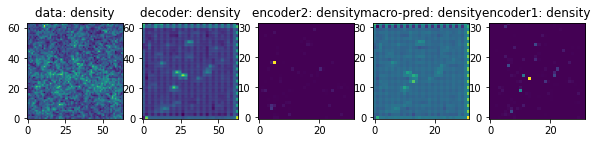

 23%|█████████████████████████▌                                                                                   | 117/500 [01:24<04:40,  1.37it/s]

Epoch 116, train decoder Loss: 16175.52669271


 24%|█████████████████████████▋                                                                                   | 118/500 [01:25<04:29,  1.42it/s]

Epoch 117, train decoder Loss: 16174.61442057


 24%|█████████████████████████▉                                                                                   | 119/500 [01:25<04:24,  1.44it/s]

Epoch 118, train decoder Loss: 16173.63671875


 24%|██████████████████████████▏                                                                                  | 120/500 [01:26<04:20,  1.46it/s]

Epoch 119, train decoder Loss: 16172.86425781
Epoch 120, train decoder Loss: 16171.89322917
save
--------Epoch 120, valid decoder Loss: 16596.48144531, macro Loss: 18.98127747, mean Loss: nan


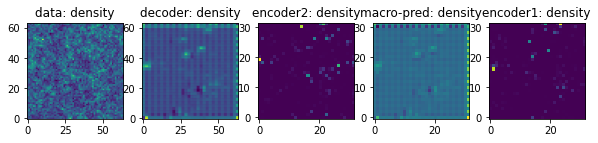

 24%|██████████████████████████▌                                                                                  | 122/500 [01:28<04:39,  1.35it/s]

Epoch 121, train decoder Loss: 16170.97835286


 25%|██████████████████████████▊                                                                                  | 123/500 [01:28<04:29,  1.40it/s]

Epoch 122, train decoder Loss: 16170.08740234


 25%|███████████████████████████                                                                                  | 124/500 [01:29<04:25,  1.42it/s]

Epoch 123, train decoder Loss: 16169.22688802


 25%|███████████████████████████▎                                                                                 | 125/500 [01:30<04:37,  1.35it/s]

Epoch 124, train decoder Loss: 16168.41471354
Epoch 125, train decoder Loss: 16167.71142578
save
--------Epoch 125, valid decoder Loss: 16590.53369141, macro Loss: 18.08450508, mean Loss: nan


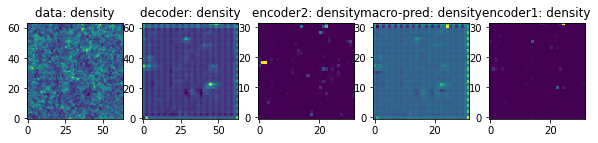

 25%|███████████████████████████▋                                                                                 | 127/500 [01:32<05:01,  1.24it/s]

Epoch 126, train decoder Loss: 16166.87906901


 26%|███████████████████████████▉                                                                                 | 128/500 [01:33<05:18,  1.17it/s]

Epoch 127, train decoder Loss: 16166.16682943


 26%|████████████████████████████                                                                                 | 129/500 [01:33<05:11,  1.19it/s]

Epoch 128, train decoder Loss: 16165.05468750


 26%|████████████████████████████▎                                                                                | 130/500 [01:34<04:53,  1.26it/s]

Epoch 129, train decoder Loss: 16164.11604818
Epoch 130, train decoder Loss: 16163.20996094
save
--------Epoch 130, valid decoder Loss: 16586.60302734, macro Loss: 17.37405968, mean Loss: nan


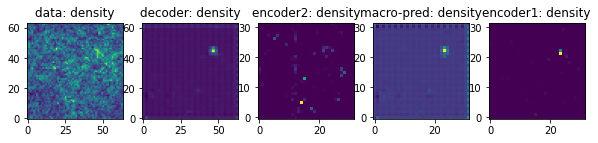

 26%|████████████████████████████▊                                                                                | 132/500 [01:36<04:54,  1.25it/s]

Epoch 131, train decoder Loss: 16162.51269531


 27%|████████████████████████████▉                                                                                | 133/500 [01:36<04:38,  1.32it/s]

Epoch 132, train decoder Loss: 16161.49869792


 27%|█████████████████████████████▏                                                                               | 134/500 [01:37<04:27,  1.37it/s]

Epoch 133, train decoder Loss: 16160.71044922


 27%|█████████████████████████████▍                                                                               | 135/500 [01:38<04:22,  1.39it/s]

Epoch 134, train decoder Loss: 16159.88590495
Epoch 135, train decoder Loss: 16159.02246094
save
--------Epoch 135, valid decoder Loss: 16583.30126953, macro Loss: 16.90924454, mean Loss: nan


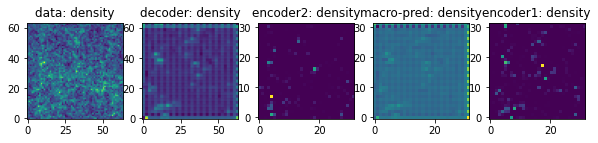

 27%|█████████████████████████████▊                                                                               | 137/500 [01:39<04:36,  1.32it/s]

Epoch 136, train decoder Loss: 16158.14436849


 28%|██████████████████████████████                                                                               | 138/500 [01:40<04:25,  1.36it/s]

Epoch 137, train decoder Loss: 16157.13004557


 28%|██████████████████████████████▎                                                                              | 139/500 [01:41<04:17,  1.40it/s]

Epoch 138, train decoder Loss: 16156.30826823


 28%|██████████████████████████████▌                                                                              | 140/500 [01:41<04:09,  1.44it/s]

Epoch 139, train decoder Loss: 16155.36832682
Epoch 140, train decoder Loss: 16154.50065104
save
--------Epoch 140, valid decoder Loss: 16582.67431641, macro Loss: 16.44368362, mean Loss: nan


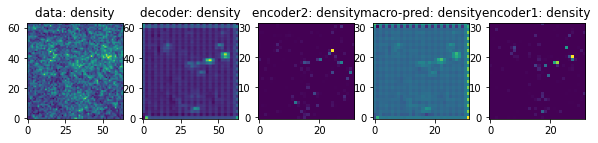

 28%|██████████████████████████████▉                                                                              | 142/500 [01:43<04:25,  1.35it/s]

Epoch 141, train decoder Loss: 16153.61848958


 29%|███████████████████████████████▏                                                                             | 143/500 [01:44<04:15,  1.40it/s]

Epoch 142, train decoder Loss: 16152.62353516


 29%|███████████████████████████████▍                                                                             | 144/500 [01:44<04:07,  1.44it/s]

Epoch 143, train decoder Loss: 16151.70800781


 29%|███████████████████████████████▌                                                                             | 145/500 [01:45<04:00,  1.48it/s]

Epoch 144, train decoder Loss: 16150.75585938
Epoch 145, train decoder Loss: 16149.80094401
save
--------Epoch 145, valid decoder Loss: 16575.76855469, macro Loss: 16.16224194, mean Loss: nan


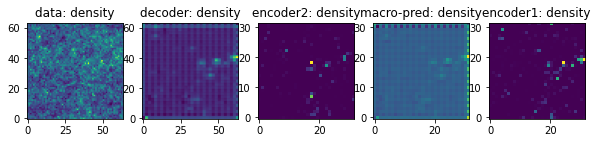

 29%|████████████████████████████████                                                                             | 147/500 [01:47<04:18,  1.36it/s]

Epoch 146, train decoder Loss: 16148.83512370


 30%|████████████████████████████████▎                                                                            | 148/500 [01:47<04:08,  1.42it/s]

Epoch 147, train decoder Loss: 16147.78385417


 30%|████████████████████████████████▍                                                                            | 149/500 [01:48<04:01,  1.45it/s]

Epoch 148, train decoder Loss: 16146.68196615


 30%|████████████████████████████████▋                                                                            | 150/500 [01:49<04:05,  1.43it/s]

Epoch 149, train decoder Loss: 16145.47412109
Epoch 150, train decoder Loss: 16144.37792969
save
--------Epoch 150, valid decoder Loss: 16573.88134766, macro Loss: 15.91061926, mean Loss: nan


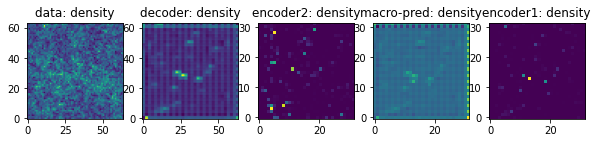

 30%|█████████████████████████████████▏                                                                           | 152/500 [01:50<04:20,  1.34it/s]

Epoch 151, train decoder Loss: 16143.11637370


 31%|█████████████████████████████████▎                                                                           | 153/500 [01:51<04:09,  1.39it/s]

Epoch 152, train decoder Loss: 16141.99283854


 31%|█████████████████████████████████▌                                                                           | 154/500 [01:52<04:02,  1.43it/s]

Epoch 153, train decoder Loss: 16140.86035156


 31%|█████████████████████████████████▊                                                                           | 155/500 [01:52<03:57,  1.45it/s]

Epoch 154, train decoder Loss: 16139.40234375
Epoch 155, train decoder Loss: 16138.14680990
save
--------Epoch 155, valid decoder Loss: 16568.85888672, macro Loss: 15.71156979, mean Loss: nan


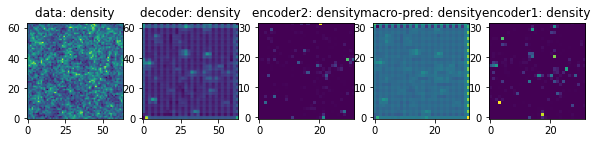

 31%|██████████████████████████████████▏                                                                          | 157/500 [01:54<04:14,  1.35it/s]

Epoch 156, train decoder Loss: 16136.67301432


 32%|██████████████████████████████████▍                                                                          | 158/500 [01:55<04:05,  1.40it/s]

Epoch 157, train decoder Loss: 16135.21126302


 32%|██████████████████████████████████▋                                                                          | 159/500 [01:55<03:56,  1.44it/s]

Epoch 158, train decoder Loss: 16133.59244792


 32%|██████████████████████████████████▉                                                                          | 160/500 [01:56<03:50,  1.47it/s]

Epoch 159, train decoder Loss: 16131.97542318
Epoch 160, train decoder Loss: 16130.47509766
save
--------Epoch 160, valid decoder Loss: 16562.71826172, macro Loss: 15.73265219, mean Loss: nan


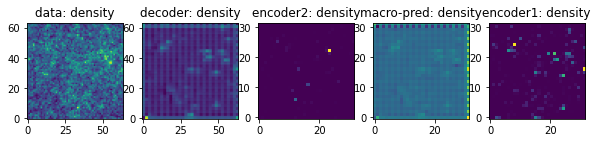

 32%|███████████████████████████████████▎                                                                         | 162/500 [01:57<04:06,  1.37it/s]

Epoch 161, train decoder Loss: 16128.70963542


 33%|███████████████████████████████████▌                                                                         | 163/500 [01:58<03:57,  1.42it/s]

Epoch 162, train decoder Loss: 16126.93717448


 33%|███████████████████████████████████▊                                                                         | 164/500 [01:59<03:52,  1.45it/s]

Epoch 163, train decoder Loss: 16125.17871094


 33%|███████████████████████████████████▉                                                                         | 165/500 [01:59<03:47,  1.47it/s]

Epoch 164, train decoder Loss: 16123.23974609
Epoch 165, train decoder Loss: 16121.45247396
save
--------Epoch 165, valid decoder Loss: 16553.37304688, macro Loss: 15.80864525, mean Loss: nan


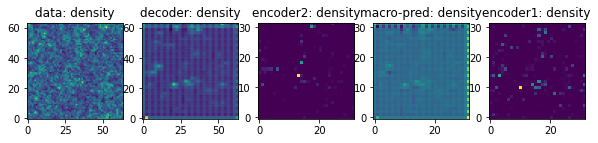

 33%|████████████████████████████████████▍                                                                        | 167/500 [02:01<04:03,  1.37it/s]

Epoch 166, train decoder Loss: 16119.47558594


 34%|████████████████████████████████████▌                                                                        | 168/500 [02:02<03:55,  1.41it/s]

Epoch 167, train decoder Loss: 16117.46061198


 34%|████████████████████████████████████▊                                                                        | 169/500 [02:02<03:48,  1.45it/s]

Epoch 168, train decoder Loss: 16115.52083333


 34%|█████████████████████████████████████                                                                        | 170/500 [02:03<03:43,  1.48it/s]

Epoch 169, train decoder Loss: 16113.56022135
Epoch 170, train decoder Loss: 16111.45621745
save
--------Epoch 170, valid decoder Loss: 16541.82617188, macro Loss: 15.82593679, mean Loss: nan


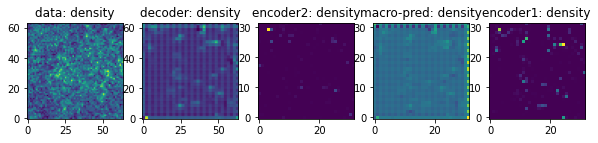

 34%|█████████████████████████████████████▍                                                                       | 172/500 [02:05<04:00,  1.36it/s]

Epoch 171, train decoder Loss: 16109.42399089


 35%|█████████████████████████████████████▋                                                                       | 173/500 [02:05<03:52,  1.41it/s]

Epoch 172, train decoder Loss: 16107.49104818


 35%|█████████████████████████████████████▉                                                                       | 174/500 [02:06<03:45,  1.45it/s]

Epoch 173, train decoder Loss: 16105.53499349


 35%|██████████████████████████████████████▏                                                                      | 175/500 [02:07<03:44,  1.45it/s]

Epoch 174, train decoder Loss: 16103.45703125
Epoch 175, train decoder Loss: 16101.63492839
save
--------Epoch 175, valid decoder Loss: 16531.71484375, macro Loss: 15.83109665, mean Loss: nan


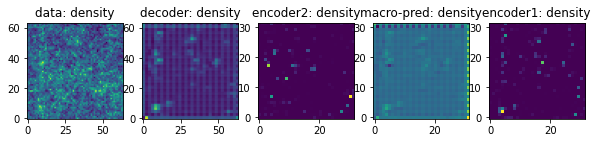

 35%|██████████████████████████████████████▌                                                                      | 177/500 [02:08<04:07,  1.30it/s]

Epoch 176, train decoder Loss: 16099.63476562


 36%|██████████████████████████████████████▊                                                                      | 178/500 [02:09<03:55,  1.37it/s]

Epoch 177, train decoder Loss: 16097.65625000


 36%|███████████████████████████████████████                                                                      | 179/500 [02:10<03:47,  1.41it/s]

Epoch 178, train decoder Loss: 16095.73209635


 36%|███████████████████████████████████████▏                                                                     | 180/500 [02:10<03:40,  1.45it/s]

Epoch 179, train decoder Loss: 16093.88509115
Epoch 180, train decoder Loss: 16092.21858724
save
--------Epoch 180, valid decoder Loss: 16523.16748047, macro Loss: 15.81341076, mean Loss: nan


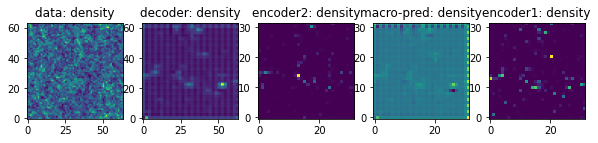

 36%|███████████████████████████████████████▋                                                                     | 182/500 [02:12<03:54,  1.35it/s]

Epoch 181, train decoder Loss: 16090.42073568


 37%|███████████████████████████████████████▉                                                                     | 183/500 [02:13<03:45,  1.41it/s]

Epoch 182, train decoder Loss: 16088.38346354


 37%|████████████████████████████████████████                                                                     | 184/500 [02:13<03:38,  1.45it/s]

Epoch 183, train decoder Loss: 16086.74039714


 37%|████████████████████████████████████████▎                                                                    | 185/500 [02:14<03:33,  1.48it/s]

Epoch 184, train decoder Loss: 16085.02164714
Epoch 185, train decoder Loss: 16083.36279297
save
--------Epoch 185, valid decoder Loss: 16512.47021484, macro Loss: 15.61875486, mean Loss: nan


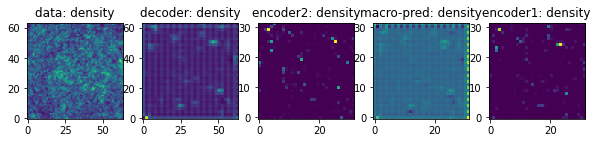

 37%|████████████████████████████████████████▊                                                                    | 187/500 [02:15<03:48,  1.37it/s]

Epoch 186, train decoder Loss: 16081.96321615


 38%|████████████████████████████████████████▉                                                                    | 188/500 [02:16<03:39,  1.42it/s]

Epoch 187, train decoder Loss: 16080.19287109


 38%|█████████████████████████████████████████▏                                                                   | 189/500 [02:17<03:33,  1.46it/s]

Epoch 188, train decoder Loss: 16078.66471354


 38%|█████████████████████████████████████████▍                                                                   | 190/500 [02:17<03:28,  1.49it/s]

Epoch 189, train decoder Loss: 16077.12727865
Epoch 190, train decoder Loss: 16075.68277995
save
--------Epoch 190, valid decoder Loss: 16505.04980469, macro Loss: 15.56680918, mean Loss: nan


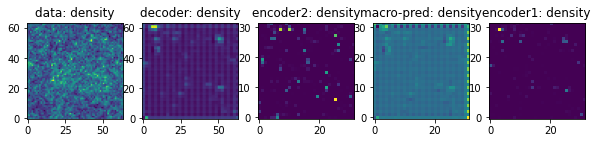

 38%|█████████████████████████████████████████▊                                                                   | 192/500 [02:19<03:44,  1.37it/s]

Epoch 191, train decoder Loss: 16074.19303385


 39%|██████████████████████████████████████████                                                                   | 193/500 [02:20<03:35,  1.42it/s]

Epoch 192, train decoder Loss: 16072.73795573


 39%|██████████████████████████████████████████▎                                                                  | 194/500 [02:20<03:29,  1.46it/s]

Epoch 193, train decoder Loss: 16071.31347656


 39%|██████████████████████████████████████████▌                                                                  | 195/500 [02:21<03:24,  1.49it/s]

Epoch 194, train decoder Loss: 16069.85677083
Epoch 195, train decoder Loss: 16068.41699219
save
--------Epoch 195, valid decoder Loss: 16496.66503906, macro Loss: 15.42948103, mean Loss: nan


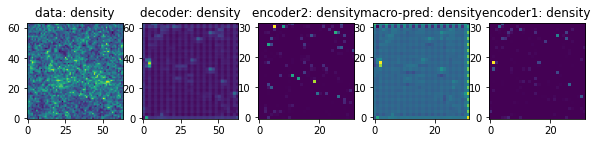

 39%|██████████████████████████████████████████▉                                                                  | 197/500 [02:22<03:39,  1.38it/s]

Epoch 196, train decoder Loss: 16067.06640625


 40%|███████████████████████████████████████████▏                                                                 | 198/500 [02:23<03:32,  1.42it/s]

Epoch 197, train decoder Loss: 16065.79264323


 40%|███████████████████████████████████████████▍                                                                 | 199/500 [02:24<03:26,  1.46it/s]

Epoch 198, train decoder Loss: 16064.53466797


 40%|███████████████████████████████████████████▌                                                                 | 200/500 [02:24<03:27,  1.44it/s]

Epoch 199, train decoder Loss: 16063.24674479
Epoch 200, train decoder Loss: 16061.99609375
save
--------Epoch 200, valid decoder Loss: 16490.99511719, macro Loss: 15.36123800, mean Loss: nan


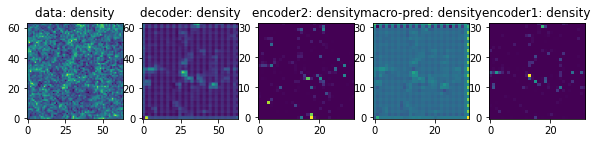

 40%|████████████████████████████████████████████                                                                 | 202/500 [02:26<03:40,  1.35it/s]

Epoch 201, train decoder Loss: 16060.80240885


 41%|████████████████████████████████████████████▎                                                                | 203/500 [02:27<03:30,  1.41it/s]

Epoch 202, train decoder Loss: 16059.58772786


 41%|████████████████████████████████████████████▍                                                                | 204/500 [02:27<03:23,  1.45it/s]

Epoch 203, train decoder Loss: 16058.39420573


 41%|████████████████████████████████████████████▋                                                                | 205/500 [02:28<03:19,  1.48it/s]

Epoch 204, train decoder Loss: 16057.23144531
Epoch 205, train decoder Loss: 16056.05078125
save
--------Epoch 205, valid decoder Loss: 16484.60253906, macro Loss: 15.34493732, mean Loss: nan


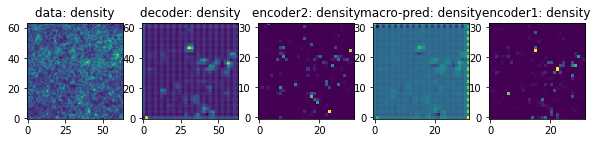

 41%|█████████████████████████████████████████████▏                                                               | 207/500 [02:30<03:32,  1.38it/s]

Epoch 206, train decoder Loss: 16054.92545573


 42%|█████████████████████████████████████████████▎                                                               | 208/500 [02:30<03:24,  1.43it/s]

Epoch 207, train decoder Loss: 16053.82128906


 42%|█████████████████████████████████████████████▌                                                               | 209/500 [02:31<03:18,  1.46it/s]

Epoch 208, train decoder Loss: 16052.79003906


 42%|█████████████████████████████████████████████▊                                                               | 210/500 [02:32<03:14,  1.49it/s]

Epoch 209, train decoder Loss: 16051.70638021
Epoch 210, train decoder Loss: 16050.74527995
save
--------Epoch 210, valid decoder Loss: 16479.69384766, macro Loss: 15.17581892, mean Loss: nan


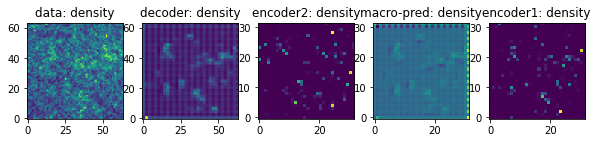

 42%|██████████████████████████████████████████████▏                                                              | 212/500 [02:33<03:28,  1.38it/s]

Epoch 211, train decoder Loss: 16049.87076823


 43%|██████████████████████████████████████████████▍                                                              | 213/500 [02:34<03:20,  1.43it/s]

Epoch 212, train decoder Loss: 16048.78841146


 43%|██████████████████████████████████████████████▋                                                              | 214/500 [02:34<03:15,  1.47it/s]

Epoch 213, train decoder Loss: 16047.71598307


 43%|██████████████████████████████████████████████▊                                                              | 215/500 [02:35<03:11,  1.49it/s]

Epoch 214, train decoder Loss: 16046.75162760
Epoch 215, train decoder Loss: 16045.80957031
save
--------Epoch 215, valid decoder Loss: 16474.40332031, macro Loss: 15.16856956, mean Loss: nan


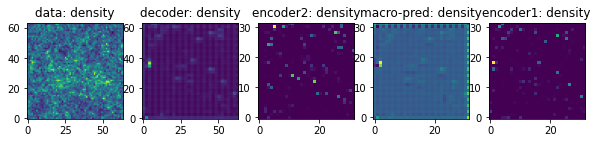

 43%|███████████████████████████████████████████████▎                                                             | 217/500 [02:37<03:24,  1.38it/s]

Epoch 216, train decoder Loss: 16044.85449219


 44%|███████████████████████████████████████████████▌                                                             | 218/500 [02:37<03:16,  1.43it/s]

Epoch 217, train decoder Loss: 16043.93261719


 44%|███████████████████████████████████████████████▋                                                             | 219/500 [02:38<03:11,  1.47it/s]

Epoch 218, train decoder Loss: 16043.02539062


 44%|███████████████████████████████████████████████▉                                                             | 220/500 [02:39<03:07,  1.49it/s]

Epoch 219, train decoder Loss: 16042.12955729
Epoch 220, train decoder Loss: 16041.22395833
save
--------Epoch 220, valid decoder Loss: 16471.07226562, macro Loss: 15.08443546, mean Loss: nan


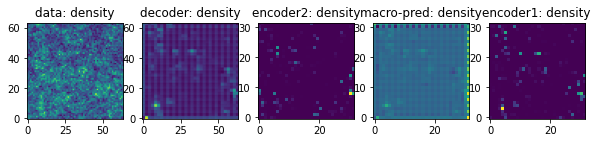

 44%|████████████████████████████████████████████████▍                                                            | 222/500 [02:40<03:22,  1.37it/s]

Epoch 221, train decoder Loss: 16040.62402344


 45%|████████████████████████████████████████████████▌                                                            | 223/500 [02:41<03:16,  1.41it/s]

Epoch 222, train decoder Loss: 16039.88378906


 45%|████████████████████████████████████████████████▊                                                            | 224/500 [02:42<03:10,  1.45it/s]

Epoch 223, train decoder Loss: 16038.72460938


 45%|█████████████████████████████████████████████████                                                            | 225/500 [02:42<03:12,  1.43it/s]

Epoch 224, train decoder Loss: 16037.94856771
Epoch 225, train decoder Loss: 16037.36409505
save
--------Epoch 225, valid decoder Loss: 16465.54394531, macro Loss: 15.05308342, mean Loss: nan


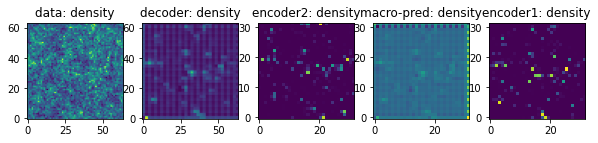

 45%|█████████████████████████████████████████████████▍                                                           | 227/500 [02:44<03:23,  1.34it/s]

Epoch 226, train decoder Loss: 16036.34733073


 46%|█████████████████████████████████████████████████▋                                                           | 228/500 [02:45<03:13,  1.40it/s]

Epoch 227, train decoder Loss: 16035.60579427


 46%|█████████████████████████████████████████████████▉                                                           | 229/500 [02:45<03:07,  1.45it/s]

Epoch 228, train decoder Loss: 16034.81445312


 46%|██████████████████████████████████████████████████▏                                                          | 230/500 [02:46<03:02,  1.48it/s]

Epoch 229, train decoder Loss: 16033.96468099
Epoch 230, train decoder Loss: 16033.20247396
save
--------Epoch 230, valid decoder Loss: 16462.00683594, macro Loss: 15.03292274, mean Loss: nan


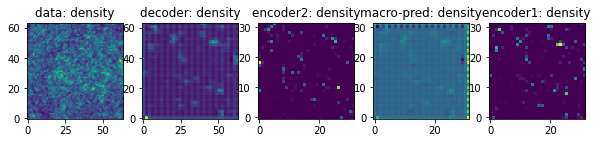

 46%|██████████████████████████████████████████████████▌                                                          | 232/500 [02:47<03:15,  1.37it/s]

Epoch 231, train decoder Loss: 16032.58235677


 47%|██████████████████████████████████████████████████▊                                                          | 233/500 [02:48<03:08,  1.42it/s]

Epoch 232, train decoder Loss: 16031.84391276


 47%|███████████████████████████████████████████████████                                                          | 234/500 [02:49<03:02,  1.46it/s]

Epoch 233, train decoder Loss: 16031.24186198


 47%|███████████████████████████████████████████████████▏                                                         | 235/500 [02:49<02:58,  1.48it/s]

Epoch 234, train decoder Loss: 16030.59830729
Epoch 235, train decoder Loss: 16030.07486979
save
--------Epoch 235, valid decoder Loss: 16459.76318359, macro Loss: 15.02486992, mean Loss: nan


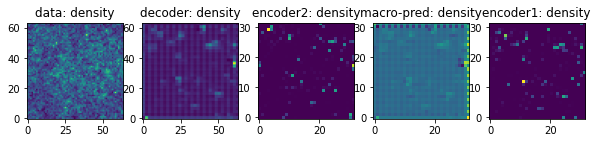

 47%|███████████████████████████████████████████████████▋                                                         | 237/500 [02:51<03:21,  1.30it/s]

Epoch 236, train decoder Loss: 16029.27718099


 48%|███████████████████████████████████████████████████▉                                                         | 238/500 [02:52<03:11,  1.37it/s]

Epoch 237, train decoder Loss: 16028.76953125


 48%|████████████████████████████████████████████████████                                                         | 239/500 [02:52<03:04,  1.42it/s]

Epoch 238, train decoder Loss: 16028.34456380


 48%|████████████████████████████████████████████████████▎                                                        | 240/500 [02:53<02:58,  1.45it/s]

Epoch 239, train decoder Loss: 16027.80517578
Epoch 240, train decoder Loss: 16027.24088542
save
--------Epoch 240, valid decoder Loss: 16458.93457031, macro Loss: 15.00564098, mean Loss: nan


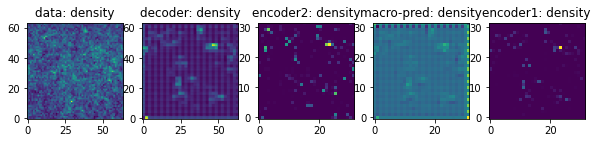

 48%|████████████████████████████████████████████████████▊                                                        | 242/500 [02:55<03:11,  1.34it/s]

Epoch 241, train decoder Loss: 16026.51904297


 49%|████████████████████████████████████████████████████▉                                                        | 243/500 [02:55<03:03,  1.40it/s]

Epoch 242, train decoder Loss: 16025.93880208


 49%|█████████████████████████████████████████████████████▏                                                       | 244/500 [02:56<02:57,  1.44it/s]

Epoch 243, train decoder Loss: 16025.39680990


 49%|█████████████████████████████████████████████████████▍                                                       | 245/500 [02:57<02:53,  1.47it/s]

Epoch 244, train decoder Loss: 16024.86897786
Epoch 245, train decoder Loss: 16024.38085938
save
--------Epoch 245, valid decoder Loss: 16455.63574219, macro Loss: 15.01062965, mean Loss: nan


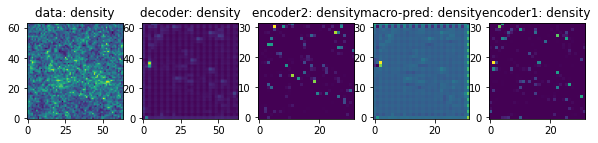

 49%|█████████████████████████████████████████████████████▊                                                       | 247/500 [02:58<03:05,  1.36it/s]

Epoch 246, train decoder Loss: 16023.85514323


 50%|██████████████████████████████████████████████████████                                                       | 248/500 [02:59<02:58,  1.41it/s]

Epoch 247, train decoder Loss: 16023.44042969


 50%|██████████████████████████████████████████████████████▎                                                      | 249/500 [03:00<02:52,  1.45it/s]

Epoch 248, train decoder Loss: 16023.00065104


 50%|██████████████████████████████████████████████████████▌                                                      | 250/500 [03:00<02:55,  1.42it/s]

Epoch 249, train decoder Loss: 16022.54964193
Epoch 250, train decoder Loss: 16022.34554036
save
--------Epoch 250, valid decoder Loss: 16453.38525391, macro Loss: 15.03773212, mean Loss: nan


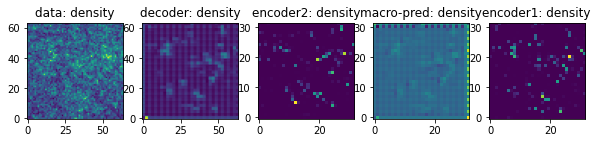

 50%|██████████████████████████████████████████████████████▉                                                      | 252/500 [03:02<03:04,  1.34it/s]

Epoch 251, train decoder Loss: 16021.67057292


 51%|███████████████████████████████████████████████████████▏                                                     | 253/500 [03:03<02:56,  1.40it/s]

Epoch 252, train decoder Loss: 16021.10628255


 51%|███████████████████████████████████████████████████████▎                                                     | 254/500 [03:03<02:50,  1.44it/s]

Epoch 253, train decoder Loss: 16020.77783203


 51%|███████████████████████████████████████████████████████▌                                                     | 255/500 [03:04<02:46,  1.47it/s]

Epoch 254, train decoder Loss: 16020.16015625
Epoch 255, train decoder Loss: 16019.71337891
save
--------Epoch 255, valid decoder Loss: 16452.48925781, macro Loss: 15.03177071, mean Loss: nan


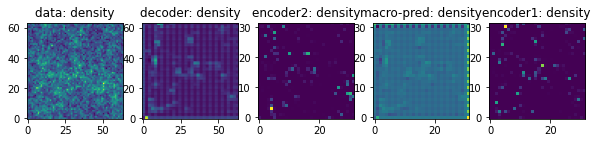

 51%|████████████████████████████████████████████████████████                                                     | 257/500 [03:06<02:56,  1.37it/s]

Epoch 256, train decoder Loss: 16019.24088542


 52%|████████████████████████████████████████████████████████▏                                                    | 258/500 [03:06<02:49,  1.42it/s]

Epoch 257, train decoder Loss: 16018.40901693


 52%|████████████████████████████████████████████████████████▍                                                    | 259/500 [03:07<02:44,  1.46it/s]

Epoch 258, train decoder Loss: 16017.74723307


 52%|████████████████████████████████████████████████████████▋                                                    | 260/500 [03:07<02:41,  1.49it/s]

Epoch 259, train decoder Loss: 16017.13264974
Epoch 260, train decoder Loss: 16016.52148438
save
--------Epoch 260, valid decoder Loss: 16450.86621094, macro Loss: 15.08969450, mean Loss: nan


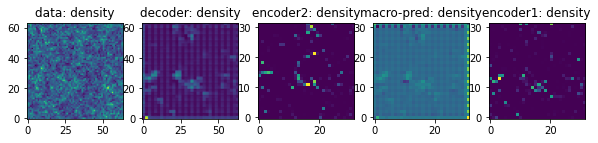

 52%|█████████████████████████████████████████████████████████                                                    | 262/500 [03:09<02:52,  1.38it/s]

Epoch 261, train decoder Loss: 16016.02067057


 53%|█████████████████████████████████████████████████████████▎                                                   | 263/500 [03:10<02:46,  1.43it/s]

Epoch 262, train decoder Loss: 16015.44026693


 53%|█████████████████████████████████████████████████████████▌                                                   | 264/500 [03:10<02:42,  1.46it/s]

Epoch 263, train decoder Loss: 16014.96256510


 53%|█████████████████████████████████████████████████████████▊                                                   | 265/500 [03:11<02:38,  1.48it/s]

Epoch 264, train decoder Loss: 16014.48014323
Epoch 265, train decoder Loss: 16013.97298177
--------Epoch 265, valid decoder Loss: 16452.04980469, macro Loss: 15.11932611, mean Loss: nan


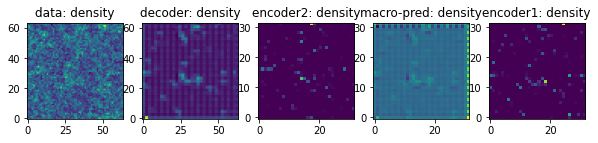

 53%|██████████████████████████████████████████████████████████▏                                                  | 267/500 [03:13<02:49,  1.37it/s]

Epoch 266, train decoder Loss: 16013.63867188


 54%|██████████████████████████████████████████████████████████▍                                                  | 268/500 [03:13<02:43,  1.42it/s]

Epoch 267, train decoder Loss: 16013.19807943


 54%|██████████████████████████████████████████████████████████▋                                                  | 269/500 [03:14<02:38,  1.46it/s]

Epoch 268, train decoder Loss: 16012.68359375


 54%|██████████████████████████████████████████████████████████▊                                                  | 270/500 [03:15<02:34,  1.49it/s]

Epoch 269, train decoder Loss: 16012.04589844
Epoch 270, train decoder Loss: 16011.62508138
save
--------Epoch 270, valid decoder Loss: 16446.87255859, macro Loss: 15.04548168, mean Loss: nan


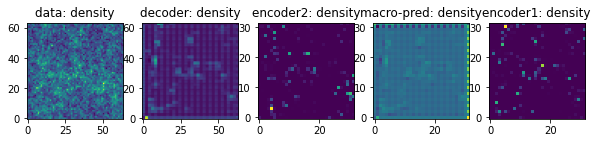

 54%|███████████████████████████████████████████████████████████▎                                                 | 272/500 [03:16<02:47,  1.36it/s]

Epoch 271, train decoder Loss: 16011.13736979


 55%|███████████████████████████████████████████████████████████▌                                                 | 273/500 [03:17<02:40,  1.42it/s]

Epoch 272, train decoder Loss: 16010.64322917


 55%|███████████████████████████████████████████████████████████▋                                                 | 274/500 [03:17<02:35,  1.45it/s]

Epoch 273, train decoder Loss: 16010.18343099


 55%|███████████████████████████████████████████████████████████▉                                                 | 275/500 [03:18<02:35,  1.45it/s]

Epoch 274, train decoder Loss: 16009.84830729
Epoch 275, train decoder Loss: 16009.28043620
save
--------Epoch 275, valid decoder Loss: 16445.21484375, macro Loss: 15.11275816, mean Loss: nan


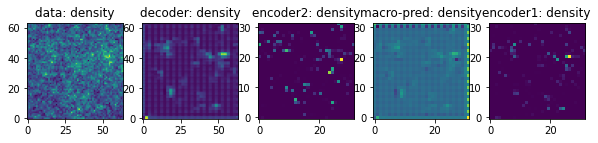

 55%|████████████████████████████████████████████████████████████▍                                                | 277/500 [03:20<02:44,  1.36it/s]

Epoch 276, train decoder Loss: 16008.84863281


 56%|████████████████████████████████████████████████████████████▌                                                | 278/500 [03:20<02:41,  1.38it/s]

Epoch 277, train decoder Loss: 16008.42480469


 56%|████████████████████████████████████████████████████████████▊                                                | 279/500 [03:21<02:35,  1.42it/s]

Epoch 278, train decoder Loss: 16007.93668620


 56%|█████████████████████████████████████████████████████████████                                                | 280/500 [03:22<02:31,  1.46it/s]

Epoch 279, train decoder Loss: 16007.45052083
Epoch 280, train decoder Loss: 16007.02897135
save
--------Epoch 280, valid decoder Loss: 16444.50488281, macro Loss: 15.03799772, mean Loss: nan


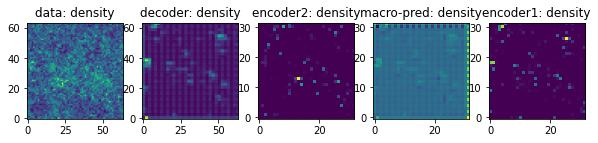

 56%|█████████████████████████████████████████████████████████████▍                                               | 282/500 [03:23<02:39,  1.36it/s]

Epoch 281, train decoder Loss: 16006.51009115


 57%|█████████████████████████████████████████████████████████████▋                                               | 283/500 [03:24<02:33,  1.41it/s]

Epoch 282, train decoder Loss: 16006.18440755


 57%|█████████████████████████████████████████████████████████████▉                                               | 284/500 [03:25<02:28,  1.45it/s]

Epoch 283, train decoder Loss: 16005.72233073


 57%|██████████████████████████████████████████████████████████████▏                                              | 285/500 [03:25<02:25,  1.48it/s]

Epoch 284, train decoder Loss: 16005.24772135
Epoch 285, train decoder Loss: 16004.74983724
save
--------Epoch 285, valid decoder Loss: 16440.78027344, macro Loss: 15.01845932, mean Loss: nan


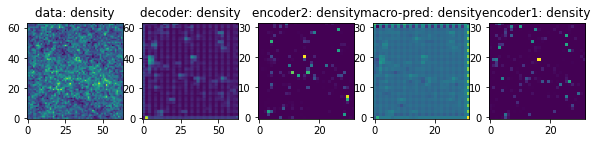

 57%|██████████████████████████████████████████████████████████████▌                                              | 287/500 [03:27<02:35,  1.37it/s]

Epoch 286, train decoder Loss: 16004.31217448


 58%|██████████████████████████████████████████████████████████████▊                                              | 288/500 [03:28<02:28,  1.42it/s]

Epoch 287, train decoder Loss: 16003.95686849


 58%|███████████████████████████████████████████████████████████████                                              | 289/500 [03:28<02:24,  1.46it/s]

Epoch 288, train decoder Loss: 16003.42008464


 58%|███████████████████████████████████████████████████████████████▏                                             | 290/500 [03:29<02:21,  1.49it/s]

Epoch 289, train decoder Loss: 16003.01627604
Epoch 290, train decoder Loss: 16002.59537760
save
--------Epoch 290, valid decoder Loss: 16438.42285156, macro Loss: 15.03202248, mean Loss: nan


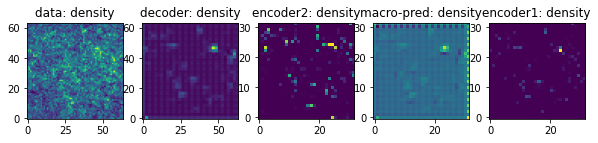

 58%|███████████████████████████████████████████████████████████████▋                                             | 292/500 [03:30<02:31,  1.38it/s]

Epoch 291, train decoder Loss: 16002.27441406


 59%|███████████████████████████████████████████████████████████████▊                                             | 293/500 [03:31<02:25,  1.43it/s]

Epoch 292, train decoder Loss: 16001.74072266


 59%|████████████████████████████████████████████████████████████████                                             | 294/500 [03:32<02:20,  1.46it/s]

Epoch 293, train decoder Loss: 16001.27750651


 59%|████████████████████████████████████████████████████████████████▎                                            | 295/500 [03:32<02:17,  1.49it/s]

Epoch 294, train decoder Loss: 16000.88020833
Epoch 295, train decoder Loss: 16000.53889974
save
--------Epoch 295, valid decoder Loss: 16437.47900391, macro Loss: 15.03807449, mean Loss: nan


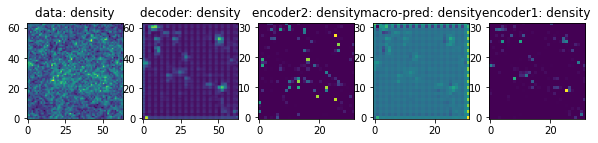

 59%|████████████████████████████████████████████████████████████████▋                                            | 297/500 [03:34<02:27,  1.38it/s]

Epoch 296, train decoder Loss: 16000.04508464


 60%|████████████████████████████████████████████████████████████████▉                                            | 298/500 [03:35<02:21,  1.43it/s]

Epoch 297, train decoder Loss: 15999.55257161


 60%|█████████████████████████████████████████████████████████████████▏                                           | 299/500 [03:35<02:17,  1.46it/s]

Epoch 298, train decoder Loss: 15999.10498047


 60%|█████████████████████████████████████████████████████████████████▍                                           | 300/500 [03:36<02:17,  1.46it/s]

Epoch 299, train decoder Loss: 15998.66276042
Epoch 300, train decoder Loss: 15998.17073568
save
--------Epoch 300, valid decoder Loss: 16436.37548828, macro Loss: 15.04924059, mean Loss: nan


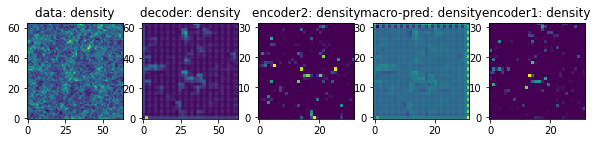

 60%|█████████████████████████████████████████████████████████████████▊                                           | 302/500 [03:38<02:24,  1.37it/s]

Epoch 301, train decoder Loss: 15997.81868490


 61%|██████████████████████████████████████████████████████████████████                                           | 303/500 [03:38<02:19,  1.41it/s]

Epoch 302, train decoder Loss: 15997.37841797


 61%|██████████████████████████████████████████████████████████████████▎                                          | 304/500 [03:39<02:14,  1.46it/s]

Epoch 303, train decoder Loss: 15997.10139974


 61%|██████████████████████████████████████████████████████████████████▍                                          | 305/500 [03:40<02:11,  1.48it/s]

Epoch 304, train decoder Loss: 15996.58186849
Epoch 305, train decoder Loss: 15996.12467448
--------Epoch 305, valid decoder Loss: 16436.78369141, macro Loss: 15.02935123, mean Loss: nan


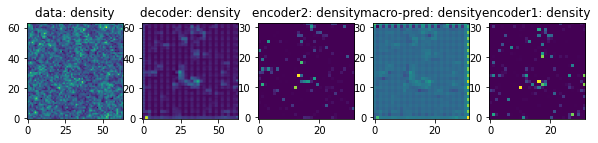

 61%|██████████████████████████████████████████████████████████████████▉                                          | 307/500 [03:41<02:20,  1.38it/s]

Epoch 306, train decoder Loss: 15995.81445312


 62%|███████████████████████████████████████████████████████████████████▏                                         | 308/500 [03:42<02:14,  1.43it/s]

Epoch 307, train decoder Loss: 15995.12825521


 62%|███████████████████████████████████████████████████████████████████▎                                         | 309/500 [03:42<02:12,  1.45it/s]

Epoch 308, train decoder Loss: 15994.69775391


 62%|███████████████████████████████████████████████████████████████████▌                                         | 310/500 [03:43<02:08,  1.48it/s]

Epoch 309, train decoder Loss: 15994.41943359
Epoch 310, train decoder Loss: 15994.02962240
save
--------Epoch 310, valid decoder Loss: 16431.90332031, macro Loss: 15.01655483, mean Loss: nan


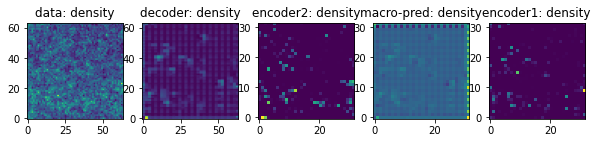

 62%|████████████████████████████████████████████████████████████████████                                         | 312/500 [03:45<02:18,  1.36it/s]

Epoch 311, train decoder Loss: 15993.38476562


 63%|████████████████████████████████████████████████████████████████████▏                                        | 313/500 [03:45<02:12,  1.41it/s]

Epoch 312, train decoder Loss: 15993.15966797


 63%|████████████████████████████████████████████████████████████████████▍                                        | 314/500 [03:46<02:08,  1.45it/s]

Epoch 313, train decoder Loss: 15992.72037760


 63%|████████████████████████████████████████████████████████████████████▋                                        | 315/500 [03:47<02:04,  1.48it/s]

Epoch 314, train decoder Loss: 15991.95393880
Epoch 315, train decoder Loss: 15991.53727214
save
--------Epoch 315, valid decoder Loss: 16430.32226562, macro Loss: 15.04078770, mean Loss: nan


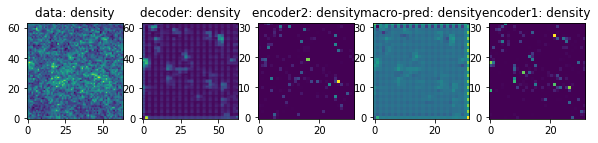

 63%|█████████████████████████████████████████████████████████████████████                                        | 317/500 [03:48<02:13,  1.37it/s]

Epoch 316, train decoder Loss: 15991.10693359


 64%|█████████████████████████████████████████████████████████████████████▎                                       | 318/500 [03:49<02:08,  1.42it/s]

Epoch 317, train decoder Loss: 15990.50651042


 64%|█████████████████████████████████████████████████████████████████████▌                                       | 319/500 [03:50<02:04,  1.46it/s]

Epoch 318, train decoder Loss: 15990.09342448


 64%|█████████████████████████████████████████████████████████████████████▊                                       | 320/500 [03:50<02:01,  1.48it/s]

Epoch 319, train decoder Loss: 15989.60546875
Epoch 320, train decoder Loss: 15989.20214844
save
--------Epoch 320, valid decoder Loss: 16426.76464844, macro Loss: 15.05652046, mean Loss: nan


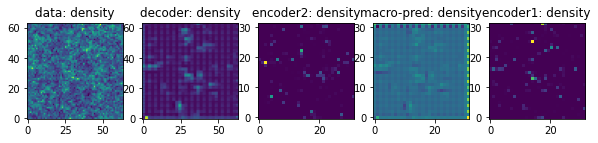

 64%|██████████████████████████████████████████████████████████████████████▏                                      | 322/500 [03:52<02:09,  1.38it/s]

Epoch 321, train decoder Loss: 15988.70214844


 65%|██████████████████████████████████████████████████████████████████████▍                                      | 323/500 [03:52<02:04,  1.42it/s]

Epoch 322, train decoder Loss: 15988.27425130


 65%|██████████████████████████████████████████████████████████████████████▋                                      | 324/500 [03:53<02:00,  1.46it/s]

Epoch 323, train decoder Loss: 15988.13264974


 65%|██████████████████████████████████████████████████████████████████████▊                                      | 325/500 [03:54<02:01,  1.45it/s]

Epoch 324, train decoder Loss: 15987.38460286
Epoch 325, train decoder Loss: 15986.78190104
save
--------Epoch 325, valid decoder Loss: 16425.26757812, macro Loss: 15.07181549, mean Loss: nan


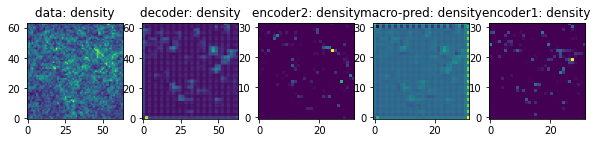

 65%|███████████████████████████████████████████████████████████████████████▎                                     | 327/500 [03:55<02:07,  1.36it/s]

Epoch 326, train decoder Loss: 15986.28206380


 66%|███████████████████████████████████████████████████████████████████████▌                                     | 328/500 [03:56<02:01,  1.41it/s]

Epoch 327, train decoder Loss: 15985.81282552


 66%|███████████████████████████████████████████████████████████████████████▋                                     | 329/500 [03:57<01:57,  1.45it/s]

Epoch 328, train decoder Loss: 15985.31673177


 66%|███████████████████████████████████████████████████████████████████████▉                                     | 330/500 [03:57<01:54,  1.48it/s]

Epoch 329, train decoder Loss: 15984.87638346
Epoch 330, train decoder Loss: 15984.41682943
save
--------Epoch 330, valid decoder Loss: 16422.69580078, macro Loss: 15.12417603, mean Loss: nan


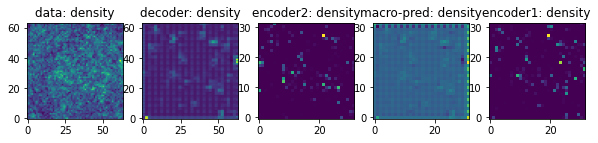

 66%|████████████████████████████████████████████████████████████████████████▍                                    | 332/500 [03:59<02:02,  1.38it/s]

Epoch 331, train decoder Loss: 15983.85725911


 67%|████████████████████████████████████████████████████████████████████████▌                                    | 333/500 [04:00<01:57,  1.42it/s]

Epoch 332, train decoder Loss: 15983.42838542


 67%|████████████████████████████████████████████████████████████████████████▊                                    | 334/500 [04:00<01:53,  1.46it/s]

Epoch 333, train decoder Loss: 15982.89648438


 67%|█████████████████████████████████████████████████████████████████████████                                    | 335/500 [04:01<01:50,  1.49it/s]

Epoch 334, train decoder Loss: 15982.62548828
Epoch 335, train decoder Loss: 15982.02083333
save
--------Epoch 335, valid decoder Loss: 16419.69628906, macro Loss: 15.10625648, mean Loss: nan


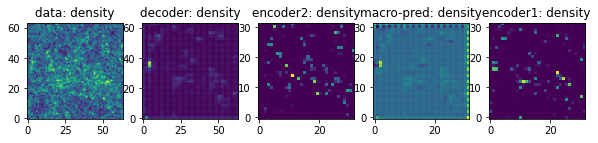

 67%|█████████████████████████████████████████████████████████████████████████▍                                   | 337/500 [04:02<01:58,  1.37it/s]

Epoch 336, train decoder Loss: 15981.31884766


 68%|█████████████████████████████████████████████████████████████████████████▋                                   | 338/500 [04:03<01:54,  1.42it/s]

Epoch 337, train decoder Loss: 15980.79329427


 68%|█████████████████████████████████████████████████████████████████████████▉                                   | 339/500 [04:04<01:50,  1.46it/s]

Epoch 338, train decoder Loss: 15980.31250000


 68%|██████████████████████████████████████████████████████████████████████████                                   | 340/500 [04:04<01:47,  1.48it/s]

Epoch 339, train decoder Loss: 15979.83186849
Epoch 340, train decoder Loss: 15979.24104818
--------Epoch 340, valid decoder Loss: 16420.51171875, macro Loss: 15.14714241, mean Loss: nan


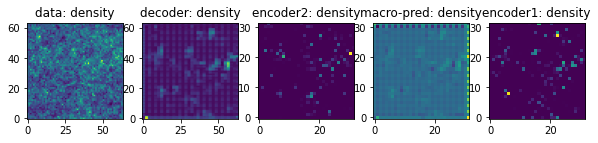

 68%|██████████████████████████████████████████████████████████████████████████▌                                  | 342/500 [04:06<01:54,  1.37it/s]

Epoch 341, train decoder Loss: 15978.70231120


 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 343/500 [04:07<01:50,  1.42it/s]

Epoch 342, train decoder Loss: 15978.19840495


 69%|██████████████████████████████████████████████████████████████████████████▉                                  | 344/500 [04:07<01:46,  1.46it/s]

Epoch 343, train decoder Loss: 15977.62646484


 69%|███████████████████████████████████████████████████████████████████████████▏                                 | 345/500 [04:08<01:44,  1.49it/s]

Epoch 344, train decoder Loss: 15976.98388672
Epoch 345, train decoder Loss: 15976.42024740
save
--------Epoch 345, valid decoder Loss: 16412.67382812, macro Loss: 15.13001204, mean Loss: nan


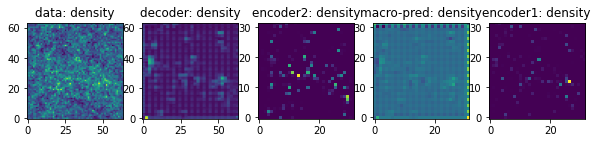

 69%|███████████████████████████████████████████████████████████████████████████▋                                 | 347/500 [04:10<01:51,  1.37it/s]

Epoch 346, train decoder Loss: 15975.92985026


 70%|███████████████████████████████████████████████████████████████████████████▊                                 | 348/500 [04:10<01:47,  1.42it/s]

Epoch 347, train decoder Loss: 15975.52978516


 70%|████████████████████████████████████████████████████████████████████████████                                 | 349/500 [04:11<01:43,  1.45it/s]

Epoch 348, train decoder Loss: 15974.87467448


 70%|████████████████████████████████████████████████████████████████████████████▎                                | 350/500 [04:12<01:43,  1.45it/s]

Epoch 349, train decoder Loss: 15974.32731120
Epoch 350, train decoder Loss: 15973.86490885
--------Epoch 350, valid decoder Loss: 16412.90283203, macro Loss: 15.17090893, mean Loss: nan


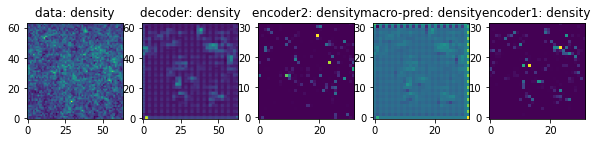

 70%|████████████████████████████████████████████████████████████████████████████▋                                | 352/500 [04:13<01:48,  1.36it/s]

Epoch 351, train decoder Loss: 15973.14404297


 71%|████████████████████████████████████████████████████████████████████████████▉                                | 353/500 [04:14<01:43,  1.42it/s]

Epoch 352, train decoder Loss: 15972.59195964


 71%|█████████████████████████████████████████████████████████████████████████████▏                               | 354/500 [04:14<01:40,  1.46it/s]

Epoch 353, train decoder Loss: 15972.06982422


 71%|█████████████████████████████████████████████████████████████████████████████▍                               | 355/500 [04:15<01:39,  1.46it/s]

Epoch 354, train decoder Loss: 15971.62597656
Epoch 355, train decoder Loss: 15971.02327474
save
--------Epoch 355, valid decoder Loss: 16408.73925781, macro Loss: 15.14780903, mean Loss: nan


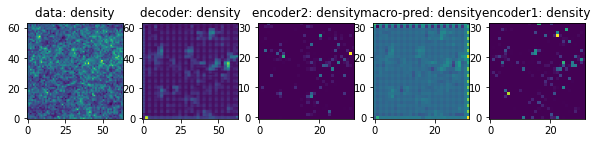

 71%|█████████████████████████████████████████████████████████████████████████████▊                               | 357/500 [04:17<01:45,  1.35it/s]

Epoch 356, train decoder Loss: 15970.45638021


 72%|██████████████████████████████████████████████████████████████████████████████                               | 358/500 [04:17<01:40,  1.41it/s]

Epoch 357, train decoder Loss: 15970.03938802


 72%|██████████████████████████████████████████████████████████████████████████████▎                              | 359/500 [04:18<01:37,  1.44it/s]

Epoch 358, train decoder Loss: 15969.45572917


 72%|██████████████████████████████████████████████████████████████████████████████▍                              | 360/500 [04:19<01:35,  1.47it/s]

Epoch 359, train decoder Loss: 15969.05859375
Epoch 360, train decoder Loss: 15968.27880859
save
--------Epoch 360, valid decoder Loss: 16404.98632812, macro Loss: 15.23985863, mean Loss: nan


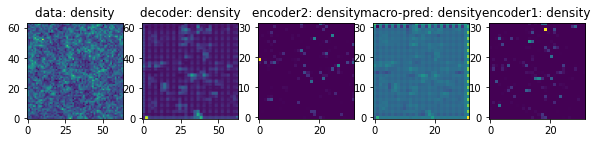

 72%|██████████████████████████████████████████████████████████████████████████████▉                              | 362/500 [04:20<01:41,  1.36it/s]

Epoch 361, train decoder Loss: 15967.53483073


 73%|███████████████████████████████████████████████████████████████████████████████▏                             | 363/500 [04:21<01:36,  1.41it/s]

Epoch 362, train decoder Loss: 15966.89518229


 73%|███████████████████████████████████████████████████████████████████████████████▎                             | 364/500 [04:22<01:33,  1.45it/s]

Epoch 363, train decoder Loss: 15966.43652344


 73%|███████████████████████████████████████████████████████████████████████████████▌                             | 365/500 [04:22<01:31,  1.48it/s]

Epoch 364, train decoder Loss: 15965.79524740
Epoch 365, train decoder Loss: 15965.09326172
--------Epoch 365, valid decoder Loss: 16406.25976562, macro Loss: 15.17813444, mean Loss: nan


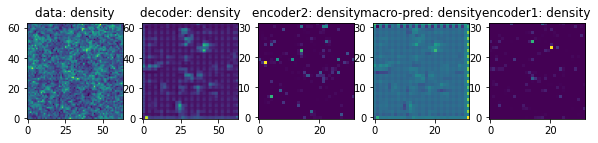

 73%|████████████████████████████████████████████████████████████████████████████████                             | 367/500 [04:24<01:36,  1.38it/s]

Epoch 366, train decoder Loss: 15964.70638021


 74%|████████████████████████████████████████████████████████████████████████████████▏                            | 368/500 [04:25<01:32,  1.43it/s]

Epoch 367, train decoder Loss: 15964.24609375


 74%|████████████████████████████████████████████████████████████████████████████████▍                            | 369/500 [04:25<01:29,  1.46it/s]

Epoch 368, train decoder Loss: 15963.56217448


 74%|████████████████████████████████████████████████████████████████████████████████▋                            | 370/500 [04:26<01:27,  1.48it/s]

Epoch 369, train decoder Loss: 15962.86246745
Epoch 370, train decoder Loss: 15962.30696615
save
--------Epoch 370, valid decoder Loss: 16402.02197266, macro Loss: 15.19241476, mean Loss: nan


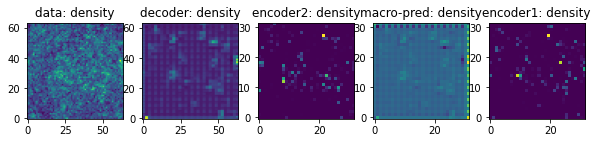

 74%|█████████████████████████████████████████████████████████████████████████████████                            | 372/500 [04:27<01:33,  1.38it/s]

Epoch 371, train decoder Loss: 15961.40234375


 75%|█████████████████████████████████████████████████████████████████████████████████▎                           | 373/500 [04:28<01:29,  1.43it/s]

Epoch 372, train decoder Loss: 15960.74414062


 75%|█████████████████████████████████████████████████████████████████████████████████▌                           | 374/500 [04:29<01:26,  1.46it/s]

Epoch 373, train decoder Loss: 15960.00341797


 75%|█████████████████████████████████████████████████████████████████████████████████▊                           | 375/500 [04:29<01:26,  1.45it/s]

Epoch 374, train decoder Loss: 15959.25374349
Epoch 375, train decoder Loss: 15958.55745443
save
--------Epoch 375, valid decoder Loss: 16393.47998047, macro Loss: 15.19764185, mean Loss: nan


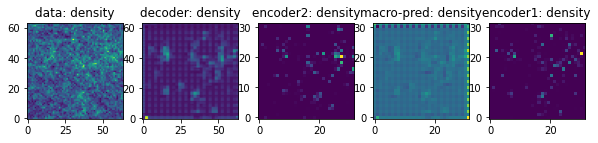

 75%|██████████████████████████████████████████████████████████████████████████████████▏                          | 377/500 [04:31<01:30,  1.36it/s]

Epoch 376, train decoder Loss: 15957.79589844


 76%|██████████████████████████████████████████████████████████████████████████████████▍                          | 378/500 [04:32<01:26,  1.41it/s]

Epoch 377, train decoder Loss: 15957.15071615


 76%|██████████████████████████████████████████████████████████████████████████████████▌                          | 379/500 [04:32<01:23,  1.45it/s]

Epoch 378, train decoder Loss: 15956.36816406


 76%|██████████████████████████████████████████████████████████████████████████████████▊                          | 380/500 [04:33<01:21,  1.48it/s]

Epoch 379, train decoder Loss: 15955.69596354
Epoch 380, train decoder Loss: 15954.95052083
save
--------Epoch 380, valid decoder Loss: 16389.35693359, macro Loss: 15.18991852, mean Loss: nan


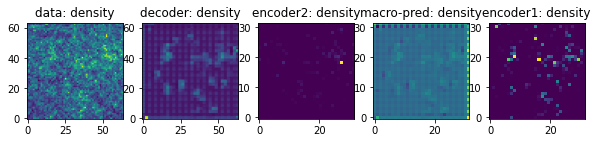

 76%|███████████████████████████████████████████████████████████████████████████████████▎                         | 382/500 [04:35<01:26,  1.37it/s]

Epoch 381, train decoder Loss: 15954.23404948


 77%|███████████████████████████████████████████████████████████████████████████████████▍                         | 383/500 [04:35<01:22,  1.42it/s]

Epoch 382, train decoder Loss: 15953.48535156


 77%|███████████████████████████████████████████████████████████████████████████████████▋                         | 384/500 [04:36<01:19,  1.45it/s]

Epoch 383, train decoder Loss: 15952.74837240


 77%|███████████████████████████████████████████████████████████████████████████████████▉                         | 385/500 [04:37<01:17,  1.48it/s]

Epoch 384, train decoder Loss: 15952.01057943
Epoch 385, train decoder Loss: 15951.24869792
save
--------Epoch 385, valid decoder Loss: 16385.71093750, macro Loss: 15.19317913, mean Loss: nan


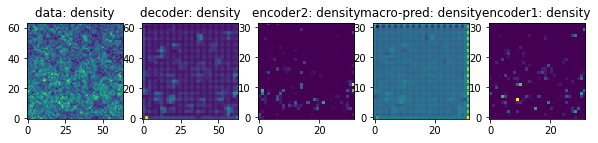

 77%|████████████████████████████████████████████████████████████████████████████████████▎                        | 387/500 [04:38<01:22,  1.37it/s]

Epoch 386, train decoder Loss: 15950.56884766


 78%|████████████████████████████████████████████████████████████████████████████████████▌                        | 388/500 [04:39<01:18,  1.42it/s]

Epoch 387, train decoder Loss: 15949.79427083


 78%|████████████████████████████████████████████████████████████████████████████████████▊                        | 389/500 [04:39<01:16,  1.46it/s]

Epoch 388, train decoder Loss: 15948.96061198


 78%|█████████████████████████████████████████████████████████████████████████████████████                        | 390/500 [04:40<01:14,  1.49it/s]

Epoch 389, train decoder Loss: 15948.32210286
Epoch 390, train decoder Loss: 15947.56868490
save
--------Epoch 390, valid decoder Loss: 16379.61816406, macro Loss: 15.19394541, mean Loss: nan


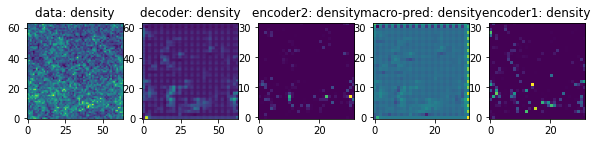

 78%|█████████████████████████████████████████████████████████████████████████████████████▍                       | 392/500 [04:42<01:20,  1.34it/s]

Epoch 391, train decoder Loss: 15946.55989583


 79%|█████████████████████████████████████████████████████████████████████████████████████▋                       | 393/500 [04:42<01:17,  1.37it/s]

Epoch 392, train decoder Loss: 15945.58691406


 79%|█████████████████████████████████████████████████████████████████████████████████████▉                       | 394/500 [04:43<01:14,  1.42it/s]

Epoch 393, train decoder Loss: 15944.86409505


 79%|██████████████████████████████████████████████████████████████████████████████████████                       | 395/500 [04:44<01:12,  1.45it/s]

Epoch 394, train decoder Loss: 15943.87858073
Epoch 395, train decoder Loss: 15943.06697591
save
--------Epoch 395, valid decoder Loss: 16374.81005859, macro Loss: 15.20392799, mean Loss: nan


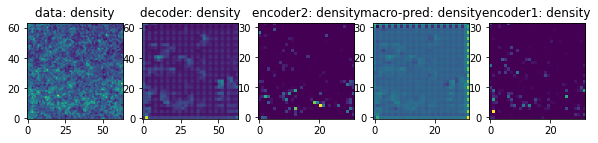

 79%|██████████████████████████████████████████████████████████████████████████████████████▌                      | 397/500 [04:45<01:16,  1.34it/s]

Epoch 396, train decoder Loss: 15942.21793620


 80%|██████████████████████████████████████████████████████████████████████████████████████▊                      | 398/500 [04:46<01:12,  1.40it/s]

Epoch 397, train decoder Loss: 15941.49967448


 80%|██████████████████████████████████████████████████████████████████████████████████████▉                      | 399/500 [04:47<01:10,  1.44it/s]

Epoch 398, train decoder Loss: 15940.64103190


 80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 400/500 [04:47<01:10,  1.42it/s]

Epoch 399, train decoder Loss: 15939.50325521
Epoch 400, train decoder Loss: 15938.68391927
save
--------Epoch 400, valid decoder Loss: 16371.00146484, macro Loss: 15.15334320, mean Loss: nan


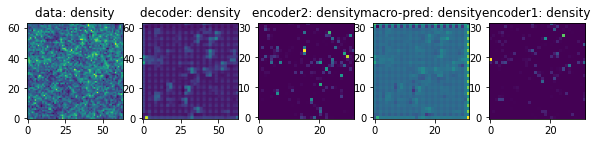

 80%|███████████████████████████████████████████████████████████████████████████████████████▋                     | 402/500 [04:49<01:13,  1.34it/s]

Epoch 401, train decoder Loss: 15937.70524089


 81%|███████████████████████████████████████████████████████████████████████████████████████▊                     | 403/500 [04:50<01:09,  1.39it/s]

Epoch 402, train decoder Loss: 15936.89314779


 81%|████████████████████████████████████████████████████████████████████████████████████████                     | 404/500 [04:51<01:10,  1.36it/s]

Epoch 403, train decoder Loss: 15936.09586589


 81%|████████████████████████████████████████████████████████████████████████████████████████▎                    | 405/500 [04:51<01:08,  1.40it/s]

Epoch 404, train decoder Loss: 15935.05826823
Epoch 405, train decoder Loss: 15933.86352539
save
--------Epoch 405, valid decoder Loss: 16364.10253906, macro Loss: 15.16702986, mean Loss: nan


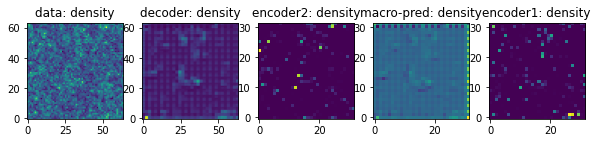

 81%|████████████████████████████████████████████████████████████████████████████████████████▋                    | 407/500 [04:53<01:10,  1.32it/s]

Epoch 406, train decoder Loss: 15932.95589193


 82%|████████████████████████████████████████████████████████████████████████████████████████▉                    | 408/500 [04:53<01:06,  1.38it/s]

Epoch 407, train decoder Loss: 15931.92301432


 82%|█████████████████████████████████████████████████████████████████████████████████████████▏                   | 409/500 [04:54<01:05,  1.40it/s]

Epoch 408, train decoder Loss: 15930.77392578


 82%|█████████████████████████████████████████████████████████████████████████████████████████▍                   | 410/500 [04:55<01:02,  1.43it/s]

Epoch 409, train decoder Loss: 15929.77360026
Epoch 410, train decoder Loss: 15928.65307617
save
--------Epoch 410, valid decoder Loss: 16357.86816406, macro Loss: 15.14753437, mean Loss: nan


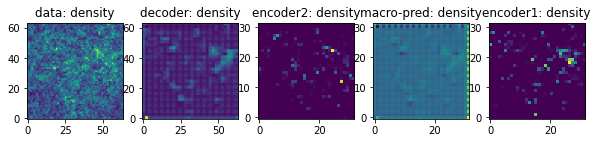

 82%|█████████████████████████████████████████████████████████████████████████████████████████▊                   | 412/500 [04:56<01:05,  1.34it/s]

Epoch 411, train decoder Loss: 15927.50944010


 83%|██████████████████████████████████████████████████████████████████████████████████████████                   | 413/500 [04:57<01:02,  1.40it/s]

Epoch 412, train decoder Loss: 15926.48128255


 83%|██████████████████████████████████████████████████████████████████████████████████████████▎                  | 414/500 [04:58<01:00,  1.43it/s]

Epoch 413, train decoder Loss: 15925.47037760


 83%|██████████████████████████████████████████████████████████████████████████████████████████▍                  | 415/500 [04:58<00:58,  1.46it/s]

Epoch 414, train decoder Loss: 15924.61962891
Epoch 415, train decoder Loss: 15923.82836914
save
--------Epoch 415, valid decoder Loss: 16353.32128906, macro Loss: 15.06881237, mean Loss: nan


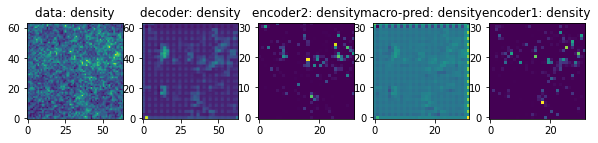

 83%|██████████████████████████████████████████████████████████████████████████████████████████▉                  | 417/500 [05:00<01:01,  1.35it/s]

Epoch 416, train decoder Loss: 15922.49723307


 84%|███████████████████████████████████████████████████████████████████████████████████████████                  | 418/500 [05:01<00:58,  1.41it/s]

Epoch 417, train decoder Loss: 15921.17708333


 84%|███████████████████████████████████████████████████████████████████████████████████████████▎                 | 419/500 [05:01<00:55,  1.45it/s]

Epoch 418, train decoder Loss: 15920.26611328


 84%|███████████████████████████████████████████████████████████████████████████████████████████▌                 | 420/500 [05:02<00:54,  1.48it/s]

Epoch 419, train decoder Loss: 15919.05891927
Epoch 420, train decoder Loss: 15917.82071940
save
--------Epoch 420, valid decoder Loss: 16341.40185547, macro Loss: 15.06166744, mean Loss: nan


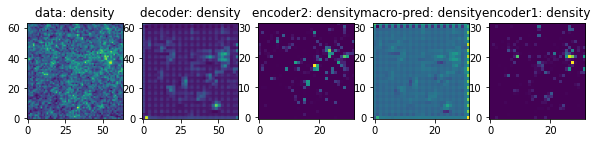

 84%|███████████████████████████████████████████████████████████████████████████████████████████▉                 | 422/500 [05:04<00:56,  1.37it/s]

Epoch 421, train decoder Loss: 15916.73258464


 85%|████████████████████████████████████████████████████████████████████████████████████████████▏                | 423/500 [05:04<00:54,  1.42it/s]

Epoch 422, train decoder Loss: 15915.46354167


 85%|████████████████████████████████████████████████████████████████████████████████████████████▍                | 424/500 [05:05<00:52,  1.46it/s]

Epoch 423, train decoder Loss: 15914.23201497


 85%|████████████████████████████████████████████████████████████████████████████████████████████▋                | 425/500 [05:06<00:52,  1.42it/s]

Epoch 424, train decoder Loss: 15913.10367839
Epoch 425, train decoder Loss: 15912.00423177
save
--------Epoch 425, valid decoder Loss: 16337.12011719, macro Loss: 15.08285904, mean Loss: nan


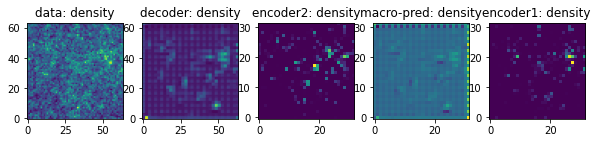

 85%|█████████████████████████████████████████████████████████████████████████████████████████████                | 427/500 [05:07<00:54,  1.34it/s]

Epoch 426, train decoder Loss: 15910.65804036


 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎               | 428/500 [05:08<00:51,  1.40it/s]

Epoch 427, train decoder Loss: 15909.51977539


 86%|█████████████████████████████████████████████████████████████████████████████████████████████▌               | 429/500 [05:09<00:49,  1.44it/s]

Epoch 428, train decoder Loss: 15908.17464193


 86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 430/500 [05:09<00:47,  1.47it/s]

Epoch 429, train decoder Loss: 15906.91601562
Epoch 430, train decoder Loss: 15905.79378255
save
--------Epoch 430, valid decoder Loss: 16330.38085938, macro Loss: 15.05490398, mean Loss: nan


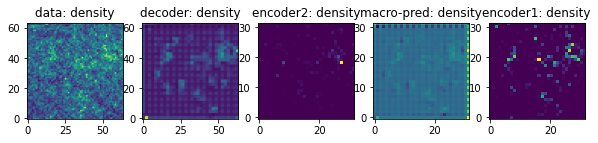

 86%|██████████████████████████████████████████████████████████████████████████████████████████████▏              | 432/500 [05:11<00:49,  1.37it/s]

Epoch 431, train decoder Loss: 15904.27994792


 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍              | 433/500 [05:11<00:47,  1.40it/s]

Epoch 432, train decoder Loss: 15902.98014323


 87%|██████████████████████████████████████████████████████████████████████████████████████████████▌              | 434/500 [05:12<00:46,  1.43it/s]

Epoch 433, train decoder Loss: 15901.62174479


 87%|██████████████████████████████████████████████████████████████████████████████████████████████▊              | 435/500 [05:13<00:44,  1.46it/s]

Epoch 434, train decoder Loss: 15900.33300781
Epoch 435, train decoder Loss: 15898.95564779
save
--------Epoch 435, valid decoder Loss: 16321.93457031, macro Loss: 14.98515224, mean Loss: nan


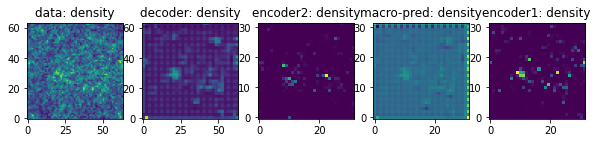

 87%|███████████████████████████████████████████████████████████████████████████████████████████████▎             | 437/500 [05:14<00:46,  1.36it/s]

Epoch 436, train decoder Loss: 15897.60074870


 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍             | 438/500 [05:15<00:44,  1.40it/s]

Epoch 437, train decoder Loss: 15896.18155924


 88%|███████████████████████████████████████████████████████████████████████████████████████████████▋             | 439/500 [05:16<00:42,  1.44it/s]

Epoch 438, train decoder Loss: 15894.72981771


 88%|███████████████████████████████████████████████████████████████████████████████████████████████▉             | 440/500 [05:16<00:40,  1.47it/s]

Epoch 439, train decoder Loss: 15893.42016602
Epoch 440, train decoder Loss: 15891.91642253
save
--------Epoch 440, valid decoder Loss: 16313.05468750, macro Loss: 14.95499516, mean Loss: nan


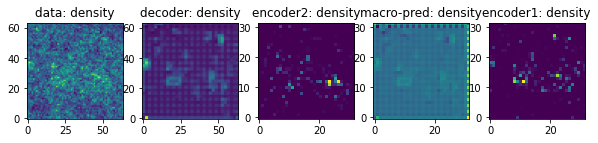

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▎            | 442/500 [05:18<00:42,  1.37it/s]

Epoch 441, train decoder Loss: 15890.28320312


 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌            | 443/500 [05:19<00:40,  1.42it/s]

Epoch 442, train decoder Loss: 15888.94864909


 89%|████████████████████████████████████████████████████████████████████████████████████████████████▊            | 444/500 [05:19<00:38,  1.45it/s]

Epoch 443, train decoder Loss: 15887.69669596


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████            | 445/500 [05:20<00:37,  1.48it/s]

Epoch 444, train decoder Loss: 15886.39648438
Epoch 445, train decoder Loss: 15884.70231120
save
--------Epoch 445, valid decoder Loss: 16303.92333984, macro Loss: 14.92109442, mean Loss: nan


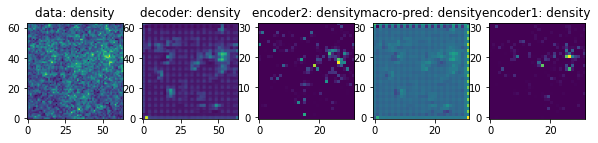

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▍           | 447/500 [05:22<00:38,  1.37it/s]

Epoch 446, train decoder Loss: 15883.07218424


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋           | 448/500 [05:22<00:36,  1.42it/s]

Epoch 447, train decoder Loss: 15881.66153971


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▉           | 449/500 [05:23<00:34,  1.46it/s]

Epoch 448, train decoder Loss: 15880.29720052


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████           | 450/500 [05:24<00:34,  1.45it/s]

Epoch 449, train decoder Loss: 15878.82600911
Epoch 450, train decoder Loss: 15877.42407227
save
--------Epoch 450, valid decoder Loss: 16296.92675781, macro Loss: 14.86966085, mean Loss: nan


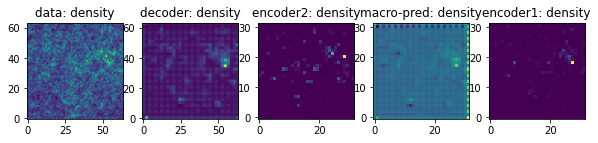

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▌          | 452/500 [05:25<00:35,  1.36it/s]

Epoch 451, train decoder Loss: 15875.94986979


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊          | 453/500 [05:26<00:33,  1.41it/s]

Epoch 452, train decoder Loss: 15874.73738607


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▉          | 454/500 [05:26<00:31,  1.45it/s]

Epoch 453, train decoder Loss: 15873.71956380


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▏         | 455/500 [05:27<00:30,  1.48it/s]

Epoch 454, train decoder Loss: 15872.10123698
Epoch 455, train decoder Loss: 15870.63395182
save
--------Epoch 455, valid decoder Loss: 16286.04199219, macro Loss: 14.77262354, mean Loss: nan


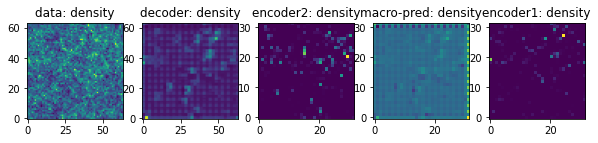

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▋         | 457/500 [05:29<00:31,  1.37it/s]

Epoch 456, train decoder Loss: 15869.29036458


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊         | 458/500 [05:29<00:29,  1.42it/s]

Epoch 457, train decoder Loss: 15867.70304362


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████         | 459/500 [05:30<00:28,  1.46it/s]

Epoch 458, train decoder Loss: 15866.24064128


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 460/500 [05:31<00:26,  1.49it/s]

Epoch 459, train decoder Loss: 15864.92976888
Epoch 460, train decoder Loss: 15863.69238281
save
--------Epoch 460, valid decoder Loss: 16277.16796875, macro Loss: 14.74239635, mean Loss: nan


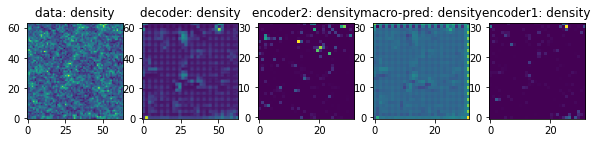

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 462/500 [05:32<00:27,  1.38it/s]

Epoch 461, train decoder Loss: 15862.22526042


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 463/500 [05:33<00:25,  1.42it/s]

Epoch 462, train decoder Loss: 15861.29687500


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 464/500 [05:34<00:24,  1.46it/s]

Epoch 463, train decoder Loss: 15859.59114583


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 465/500 [05:34<00:23,  1.49it/s]

Epoch 464, train decoder Loss: 15857.93131510
Epoch 465, train decoder Loss: 15856.75911458
save
--------Epoch 465, valid decoder Loss: 16264.23242188, macro Loss: 14.66044760, mean Loss: nan


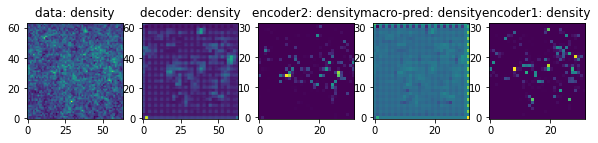

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 467/500 [05:36<00:23,  1.38it/s]

Epoch 466, train decoder Loss: 15855.37011719


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████       | 468/500 [05:36<00:22,  1.42it/s]

Epoch 467, train decoder Loss: 15853.84505208


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 469/500 [05:37<00:21,  1.46it/s]

Epoch 468, train decoder Loss: 15852.45629883


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 470/500 [05:38<00:20,  1.49it/s]

Epoch 469, train decoder Loss: 15850.87760417
Epoch 470, train decoder Loss: 15849.45849609
save
--------Epoch 470, valid decoder Loss: 16256.62255859, macro Loss: 14.62435675, mean Loss: nan


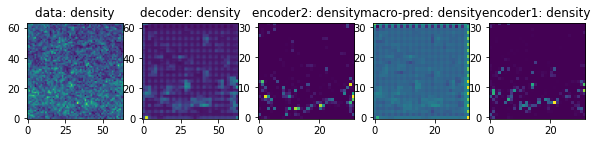

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 472/500 [05:39<00:20,  1.37it/s]

Epoch 471, train decoder Loss: 15847.87565104


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████      | 473/500 [05:40<00:19,  1.42it/s]

Epoch 472, train decoder Loss: 15847.10628255


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 474/500 [05:41<00:17,  1.46it/s]

Epoch 473, train decoder Loss: 15845.49300130


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 475/500 [05:41<00:17,  1.45it/s]

Epoch 474, train decoder Loss: 15843.52441406
Epoch 475, train decoder Loss: 15842.11181641
save
--------Epoch 475, valid decoder Loss: 16245.30175781, macro Loss: 14.56974411, mean Loss: nan


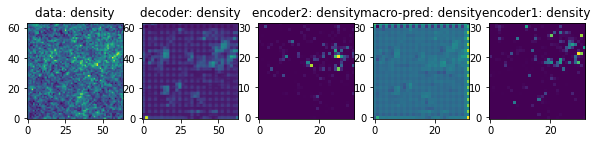

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 477/500 [05:43<00:16,  1.36it/s]

Epoch 476, train decoder Loss: 15840.55086263


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 478/500 [05:44<00:15,  1.41it/s]

Epoch 477, train decoder Loss: 15839.29028320


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 479/500 [05:44<00:14,  1.44it/s]

Epoch 478, train decoder Loss: 15837.73225911


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 480/500 [05:45<00:13,  1.47it/s]

Epoch 479, train decoder Loss: 15836.21354167
Epoch 480, train decoder Loss: 15834.64038086
save
--------Epoch 480, valid decoder Loss: 16234.64257812, macro Loss: 14.51810455, mean Loss: nan


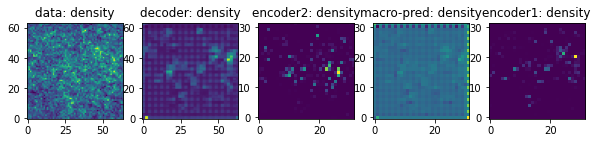

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████    | 482/500 [05:46<00:13,  1.37it/s]

Epoch 481, train decoder Loss: 15833.03271484


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 483/500 [05:47<00:11,  1.42it/s]

Epoch 482, train decoder Loss: 15831.52050781


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 484/500 [05:48<00:10,  1.46it/s]

Epoch 483, train decoder Loss: 15829.96777344


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 485/500 [05:48<00:10,  1.49it/s]

Epoch 484, train decoder Loss: 15828.44921875
Epoch 485, train decoder Loss: 15826.78719076
save
--------Epoch 485, valid decoder Loss: 16222.85400391, macro Loss: 14.41929245, mean Loss: nan


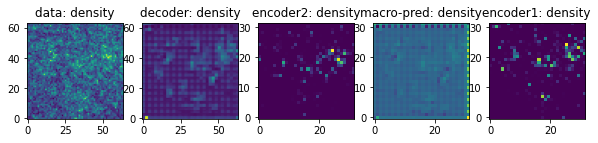

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 487/500 [05:50<00:10,  1.28it/s]

Epoch 486, train decoder Loss: 15825.27685547


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 488/500 [05:51<00:08,  1.35it/s]

Epoch 487, train decoder Loss: 15823.50065104


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 489/500 [05:52<00:07,  1.39it/s]

Epoch 488, train decoder Loss: 15821.84700521


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 490/500 [05:52<00:07,  1.42it/s]

Epoch 489, train decoder Loss: 15820.12125651
Epoch 490, train decoder Loss: 15818.49527995
save
--------Epoch 490, valid decoder Loss: 16209.64599609, macro Loss: 14.33555889, mean Loss: nan


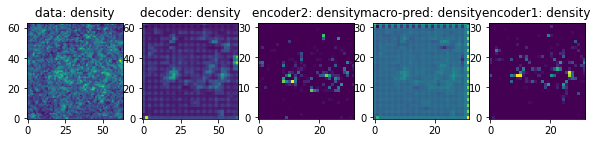

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 492/500 [05:54<00:06,  1.33it/s]

Epoch 491, train decoder Loss: 15816.80875651


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 493/500 [05:55<00:05,  1.37it/s]

Epoch 492, train decoder Loss: 15815.24698893


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 494/500 [05:55<00:04,  1.41it/s]

Epoch 493, train decoder Loss: 15813.38053385


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 495/500 [05:56<00:03,  1.44it/s]

Epoch 494, train decoder Loss: 15811.74739583
Epoch 495, train decoder Loss: 15809.83398438
save
--------Epoch 495, valid decoder Loss: 16198.42187500, macro Loss: 14.26726198, mean Loss: nan


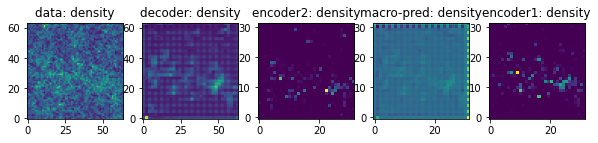

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 497/500 [05:58<00:02,  1.33it/s]

Epoch 496, train decoder Loss: 15807.80981445


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 498/500 [05:58<00:01,  1.39it/s]

Epoch 497, train decoder Loss: 15806.06925456


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [05:59<00:00,  1.43it/s]

Epoch 498, train decoder Loss: 15804.10172526


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:00<00:00,  1.39it/s]

Epoch 499, train decoder Loss: 15802.31111654


In [19]:
# training
renorm = Normalization_temp(group_size=group_size,input_dim=3,output_dim=3)
# optimizer1 = torch.optim.Adam(dynamic.parameters(), lr=0.001, weight_decay=5e-4)
optimizer2 = torch.optim.Adam(renorm.parameters(), lr=0.001, weight_decay=5e-4)

loss_ts = []
loss_vs = []
count = 0
last_valid_loss = 100000
loss_lambda = 1
for epoch in tqdm(range(500)):
    dynamic.eval()
    renorm.train()
    losst1 = []
    losst2 = []
    losst3 = []
    losst = []
#     loss=0
    for bidx, (datax,datay) in enumerate(train_loader):
#         print(datax.shape)
        encoder11 = renorm.Encoder(datax)
#         print(encoder11.shape)
        macro_pred = dynamic(encoder11)
        
        decoder = renorm.Decoder(macro_pred)
        
#         encoder21 = renorm.Encoder(datay)
        loss1 = loss_F(decoder.reshape(-1), datay.reshape(-1))
#         mean_loss = loss_F(torch.mean(encoder11.reshape(-1,3),axis=0).reshape(-1), torch.mean(datax.reshape(-1,3),axis=0).reshape(-1)) 
#         loss2 = mean_loss#+std_loss
#         loss3 = loss_F(encoder21.reshape(-1), macro_pred.reshape(-1))
        loss = loss_lambda*loss1#+(1-loss_lambda)*loss3#+loss2
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
        
        losst1.append(loss1.item())
#         losst2.append(loss2.item())
#         losst3.append(loss3.item())
        losst.append(loss.item())
            
    loss_ts.append(np.mean(losst))
#     print('Epoch {:03d}, train decoder Loss: {:.8f}, macro Loss: {:.8f}, mean Loss: {:.8f}'.format(epoch, np.mean(losst1), np.mean(losst3),np.mean(losst2)))
    print('Epoch {:03d}, train decoder Loss: {:.8f}'.format(epoch, np.mean(losst1)))
#     wandb.log({"train loss": np.mean(losst)})
    
    if epoch % 5 == 0:
        dynamic.eval()
        renorm.eval()
        loss = 0
        lossv1 = []
        lossv2 = []
        lossv3 = []
        lossv = []
        for bidx, (datax,datay) in enumerate(valid_loader):
            encoder11 = renorm.Encoder(datax)
            macro_pred = dynamic(encoder11)
            decoder = renorm.Decoder(macro_pred)
            encoder21 = renorm.Encoder(datay)
            loss1 = loss_F(decoder.reshape(-1), datay.reshape(-1))
#             mean_loss = loss_F(torch.mean(encoder11.reshape(-1,3),axis=0).reshape(-1), torch.mean(datax.reshape(-1,3),axis=0).reshape(-1)) 
#             std_loss = loss_F(torch.std(encoder.reshape(-1,3),axis=0).reshape(-1), torch.std(datax.reshape(-1,3),axis=0).reshape(-1))
#             loss2 = mean_loss#+std_loss
            loss3 = loss_F(encoder21.reshape(-1), macro_pred.reshape(-1))

            lossv1.append(loss1.item())
#             lossv2.append(loss2.item())
            lossv3.append(loss3.item())
            loss = loss_lambda*loss1+(1-loss_lambda)*loss3
            lossv.append(loss.item())

        loss_vs.append(np.mean(lossv))
        if np.mean(lossv1) > last_valid_loss:
            count += 1
            if count > 10:
                break
        if np.mean(lossv1) < last_valid_loss:
            print('save')
            count = 0
            model = {
                'dynamic':dynamic,
                'renorm':renorm
            }
#             torch.save(model,f'./models/78/renorm=78_eta={eta}_gz={group_size}_seed={seed}_pdf.pth')
            torch.save(model,f'./models/307/renorm=307_eta={eta}_gz={group_size}_seed={seed}.pth')
#             torch.save(model,f'./models/1228/renorm=1228_eta={eta}_gz={group_size}_seed={seed}.pth')
            last_valid_loss = np.mean(lossv1)
        print('--------Epoch {:03d}, valid decoder Loss: {:.8f}, macro Loss: {:.8f}, mean Loss: {:.8f}'.format(epoch, np.mean(lossv1), np.mean(lossv3),np.mean(lossv2)))
        plt.figure(figsize=(10,3))
        plt.subplot(151)
        plt.imshow(datay[0,0,:,:,0],origin='lower')
        plt.title(f'data: density')
        plt.subplot(155)
        plt.imshow(encoder11[0,0,:,:,0].detach().numpy(),origin='lower')
        plt.title(f'encoder1: density')

        
        plt.subplot(152)
        plt.imshow(decoder[0,0,:,:,0].detach().numpy(),origin='lower')
        plt.title(f'decoder: density')

        plt.subplot(153)
        plt.imshow(encoder21[0,0,:,:,0].detach().numpy(),origin='lower')
        plt.title(f'encoder2: density')

        plt.subplot(154)
        plt.imshow(macro_pred[0,0,:,:,0].detach().numpy(),origin='lower')
        plt.title(f'macro-pred: density')

        plt.show()


In [416]:
seed,eta

(2050, 1)

In [20]:
print(f'eta=1,decoder loss:{np.mean(lossv1):.5f}, macro loss:{np.mean(lossv3):.5f}')

eta=1,decoder loss:16198.42188, macro loss:14.26726


In [259]:
print(f'eta=1.25,decoder loss:{np.mean(lossv1):.5f}, macro loss:{np.mean(lossv3):.5f}')

eta=1.25,decoder loss:0.00680, macro loss:0.03652


In [248]:
print(f'eta=1.5,decoder loss:{np.mean(lossv1):.5f}, macro loss:{np.mean(lossv3):.5f}')

eta=1.5,decoder loss:0.00696, macro loss:0.02696


In [237]:
print(f'eta=1.75,decoder loss:{np.mean(lossv1):.5f}, macro loss:{np.mean(lossv3):.5f}')

eta=1.75,decoder loss:0.00699, macro loss:0.02500


In [399]:
print(f'eta=2,decoder loss:{np.mean(lossv1):.5f}, macro loss:{np.mean(lossv3):.5f}')

eta=2,decoder loss:0.00192, macro loss:0.00052


In [388]:
print(f'eta=2.25,decoder loss:{np.mean(lossv1):.5f}, macro loss:{np.mean(lossv3):.5f}')

eta=2.25,decoder loss:0.00169, macro loss:0.00047


2.25


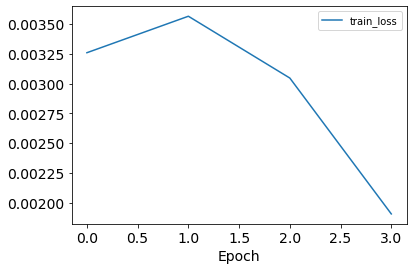

In [346]:

print(eta)
plt.plot(losst1,label='train_loss')
# plt.plot(range(0,len(losst1),5),lossv1,label='valid loss')
plt.legend()
plt.xlabel('Epoch',fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()
# with open(f'./data/loss_self_{seed}_L={L}_eta={eta}_lambda={loss_lambda}.pkl','wb') as f:
#     pkl.dump({
#         'train_loss':losst1,
#         'valid_loss':lossv1
#     },f)

In [323]:

"240324"

def deconv(input_channels, output_channels):
    layer = nn.Sequential(
        nn.ConvTranspose2d(input_channels, output_channels, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.1, inplace=True)
    )
    return layer

def conv(input_channels, output_channels, kernel_size, stride, dropout_rate=0):
    layer = nn.Sequential(
        nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, 
                  stride = stride, padding=(kernel_size - 1) // 2),
        nn.BatchNorm2d(output_channels),
        nn.LeakyReLU(0.1, inplace=True),
    )
    return layer

class Encoder(nn.Module):
    def __init__(self, input_channels, kernel_size):
        super(Encoder, self).__init__()
        self.conv1 = conv(input_channels, 8, kernel_size=kernel_size, stride = 2)
                
    def forward(self, x):
        out_conv1 = self.conv1(x)
        return out_conv1#, out_conv2#, out_conv3, out_conv4 
    
class Tempro_Spacial(nn.Module):
    def __init__(self, time_range, kernel_size):
        super(Tempro_Spacial, self).__init__()
        self.time_range = time_range
        self.filter = nn.Conv2d(time_range, 1, kernel_size = kernel_size, padding = 1, bias = False)   
        self.temporal_filter = nn.Conv1d(1, 1, kernel_size = time_range, padding = 0, bias = False)
        self.encoder = Encoder(1, kernel_size)
    def forward(self, x):
#         x.shape = b,t,l,l
        b,t,l1,l2 = x.shape
        space_conv = self.filter(x)#b,1,l,l
#         print(space_conv.shape)
        out_conv1 = self.encoder(space_conv)#b,8,l,l
        return out_conv1
    
class DynamicLearner(nn.Module):
    def __init__(self,time_range=5, time_range_out=1,L=64,input_dim=1,output_dim=1):
        super(DynamicLearner, self).__init__()
#         self.hidden_dim = hidden_dim
        
#         channel = 1
        self.time_range_out = time_range_out
        self.input_dim=input_dim
        self.output_dim=output_dim
        self.time_range = time_range
        self.kernel_size = 3
        
        self.tempro_spacial1 = Tempro_Spacial(time_range,self.kernel_size)
#         self.tempro_spacial2 = Tempro_Spacial(time_range,self.kernel_size)
#         self.tempro_spacial3 = Tempro_Spacial(time_range,self.kernel_size)
        
#         self.deconv2 = deconv(64, 32)
        self.deconv1 = deconv(8,4)
        self.output_layer = nn.Conv2d(4+input_dim, output_dim*time_range_out, kernel_size = self.kernel_size, padding = 1)  
    
        
    def forward(self, xx):
        'x.shape: b,t,l,l,f'
        b,t,l1,l2,f = xx.shape
#         print(xx.shape)
        out_conv1_rho = self.tempro_spacial1(xx[:,:,:,:,0]) #output=32,8,8,8,8
#         print(out_conv1_rho.shape)
#         de
#         out_conv1_vx = self.tempro_spacial2(xx[:,:,:,:,1])
#         out_conv1_vy = self.tempro_spacial3(xx[:,:,:,:,2]) #output = 64,64/128,64,64
        
        out_deconv0 = self.deconv1(out_conv1_rho)# + out_conv1_vx + out_conv1_vy)#output=b,4,l,l
        
        x = torch.transpose(torch.transpose(xx[:,-1,:,:,:],3,2),2,1) #b,l,l,f --> b,l,f,l --> b,f,l,l
#         print(x[:5,:5,:5,:5])
        x = xx[:,-1,:,:,:].permute(0,3,1,2)
#         print(x[:5,:5,:5,:5])
#         de
        x = torch.cat([x, out_deconv0],dim=1)#b,f+4,l,l
        x = self.output_layer(x).reshape(b,self.time_range_out,self.output_dim,l1,l2)##b,1,3,l,l
        x = torch.transpose(torch.transpose(x,2,3),3,4)#b,1,l,l,3
#         print(x.shape)
#         de
        x = nn.functional.softmax(x.reshape(b,1,l1*l2,f),dim=2).reshape(b,1,l1,l2,f)
        return x


